In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import dataframe_image as dfi

In [2]:
df = pd.read_csv(
    r"C:\Users\fabie\Documents\Python_things\10_projets\Proj_5\Data\email_dataset.csv",
    parse_dates=[
        "sent_date",
        "open_date",
        "click_date",
        "bounce_date",
        "transaction_date",
    ],
    index_col="index",
)

In [3]:
print(df.head())
print(df.info())
print(df.describe(include="all"))

                  name  account_number  \
index                                    
0         Brian Harris        84256863   
4        Travis Gibson        87296226   
8         Hector Hurst        14429475   
12     Stephanie Scott        12583440   
16       Hunter Jensen        46846333   

                                       email_name           sent_date  \
index                                                                   
0      Email 1 - Welcome to Wanderlust Adventures 2021-11-11 22:24:00   
4      Email 1 - Welcome to Wanderlust Adventures 2022-12-05 16:20:00   
8      Email 1 - Welcome to Wanderlust Adventures 2022-03-10 06:23:00   
12     Email 1 - Welcome to Wanderlust Adventures 2022-07-05 15:10:00   
16     Email 1 - Welcome to Wanderlust Adventures 2020-01-23 17:58:00   

                open_date          click_date bounce_date transaction_date  \
index                                                                        
0     2021-11-11 22:47:00 2021-11-11 

# Data wrangling

## Vérification d'activité si bounce

In [4]:
df_verif = df.copy()
df_verif["email_name"] = df_verif["email_name"].str.extract(r"^(.*?)\s*-\s*")
condition = (~df_verif["bounce_date"].isna()) & (
    (~df_verif["open_date"].isna())
    | (~df_verif["click_date"].isna())
    | (~df_verif["transaction_date"].isna())
)
result = df_verif[condition]
result = result.index

## Prépation

In [5]:
df_copy = df.copy()
df_copy = df_copy.drop(result)

In [6]:
# Réduire le nom des campagnes
df_copy["email_name"] = df_copy["email_name"].str.extract(r"^(.*?)\s*-\s*")

In [7]:
# Création de colonne copie en bool pour faciliter filtrage/sum etc....
df_copy["bounce_bool"] = (~df_copy["bounce_date"].isna()).astype(int)
df_copy["open_bool"] = (~df_copy["open_date"].isna()).astype(int)
df_copy["click_bool"] = (~df_copy["click_date"].isna()).astype(int)
df_copy["transaction_bool"] = (~df_copy["transaction_date"].isna()).astype(int)

In [8]:
df_copy

,name,account_number,email_name,sent_date,open_date,click_date,bounce_date,transaction_date,transaction_amount,bounce_bool,open_bool,click_bool,transaction_bool
index,,,,,,,,,,,,,
0,Brian Harris,84256863,Email 1,2021-11-11 22:24:00,2021-11-11 22:47:00,2021-11-11 22:51:00,NaT,NaT,NaN,0,1,1,0
4,Travis Gibson,87296226,Email 1,2022-12-05 16:20:00,2022-12-05 16:25:00,NaT,NaT,NaT,NaN,0,1,0,0
8,Hector Hurst,14429475,Email 1,2022-03-10 06:23:00,2022-03-10 07:13:00,NaT,NaT,NaT,NaN,0,1,0,0
12,Stephanie Scott,12583440,Email 1,2022-07-05 15:10:00,2022-07-05 15:40:00,NaT,NaT,NaT,NaN,0,1,0,0
16,Hunter Jensen,46846333,Email 1,2020-01-23 17:58:00,NaT,NaT,NaT,NaT,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71654,Tamara Weber,95391528,Email 3,2023-07-08 15:08:00,2023-07-08 15:45:00,NaT,NaT,NaT,NaN,0,1,0,0
71655,Tamara Weber,95391528,Email 4,2023-07-08 16:08:00,2023-07-08 16:44:00,NaT,NaT,NaT,NaN,0,1,0,0
71657,Michele Townsend,89941974,Email 2,2023-01-14 05:32:00,2023-01-14 06:13:00,NaT,NaT,NaT,NaN,0,1,0,0


In [9]:
def periode_journee(heure):
    if pd.isna(heure):
        return "Non-ouvert"
    try:
        heure = int(heure)
    except:
        return "Heure invalide"
    if 0 <= heure < 6:
        return "Nuit"
    elif 6 <= heure < 9:
        return "Petit matin"
    elif 9 <= heure < 12:
        return "Matin"
    elif 12 <= heure < 14:
        return "Midi"
    elif 14 <= heure < 18:
        return "Après-midi"
    elif 18 <= heure < 21:
        return "Soir"
    elif 21 <= heure <= 23:
        return "Fin de soirée"
    else:
        return "Heure invalide"


# Création des colonnes de segment-date (jour, mois etc)
df_copy["year"] = df_copy["sent_date"].dt.year
df_copy["month"] = df_copy["sent_date"].dt.month
df_copy["day"] = df_copy["sent_date"].dt.day
df_copy["day_week"] = df_copy["sent_date"].dt.day_name(locale="fr_FR")
df_copy["hour_sent"] = df_copy["sent_date"].dt.hour
df_copy["periode_sent"] = df_copy["hour_sent"].apply(periode_journee)
df_copy["hour_open"] = df_copy["open_date"].dt.hour
df_copy["periode_open"] = df_copy["hour_open"].apply(periode_journee)
df_copy[
    [
        "email_name",
        "sent_date",
        "year",
        "month",
        "day",
        "day_week",
        "hour_sent",
        "hour_open",
        "periode_sent",
        "periode_open",
    ]
]

,email_name,sent_date,year,month,day,day_week,hour_sent,hour_open,periode_sent,periode_open
index,,,,,,,,,,
0,Email 1,2021-11-11 22:24:00,2021,11,11,Jeudi,22,22.0,Fin de soirée,Fin de soirée
4,Email 1,2022-12-05 16:20:00,2022,12,5,Lundi,16,16.0,Après-midi,Après-midi
8,Email 1,2022-03-10 06:23:00,2022,3,10,Jeudi,6,7.0,Petit matin,Petit matin
12,Email 1,2022-07-05 15:10:00,2022,7,5,Mardi,15,15.0,Après-midi,Après-midi
16,Email 1,2020-01-23 17:58:00,2020,1,23,Jeudi,17,NaN,Après-midi,Non-ouvert
...,...,...,...,...,...,...,...,...,...,...
71654,Email 3,2023-07-08 15:08:00,2023,7,8,Samedi,15,15.0,Après-midi,Après-midi
71655,Email 4,2023-07-08 16:08:00,2023,7,8,Samedi,16,16.0,Après-midi,Après-midi
71657,Email 2,2023-01-14 05:32:00,2023,1,14,Samedi,5,6.0,Nuit,Petit matin


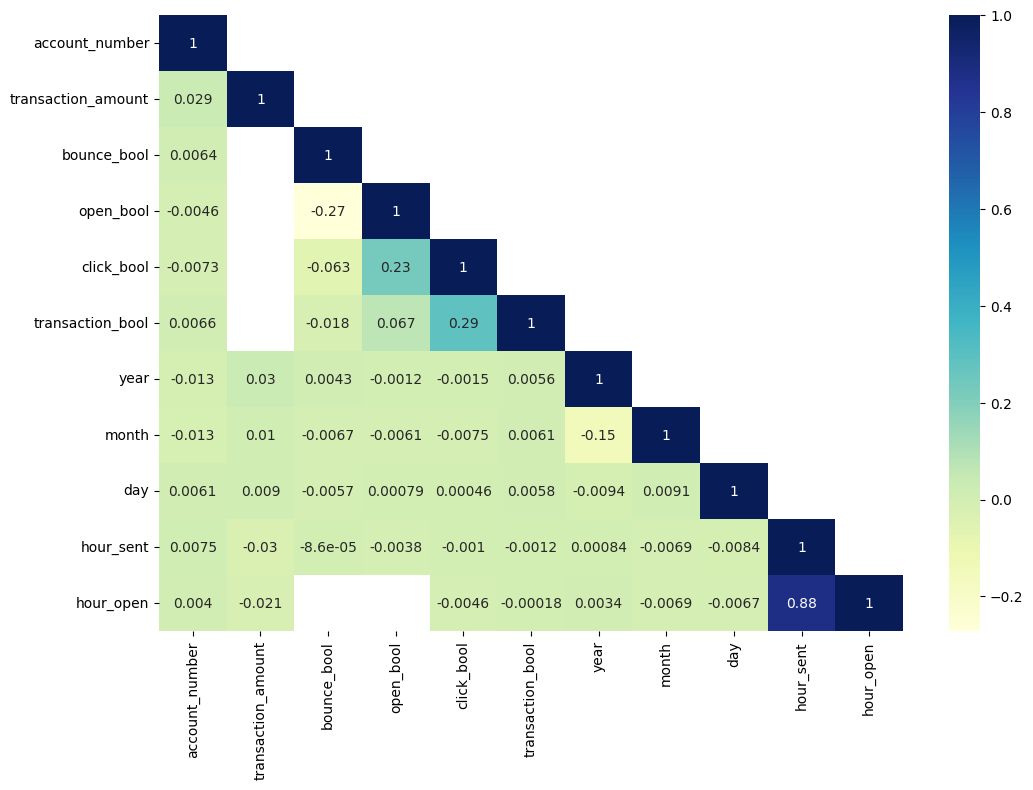

In [10]:
corr_matrix = df_copy.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap="YlGnBu", annot=True)
plt.show()

In [11]:
df_copy.to_csv(
    r"C:\Users\fabie\Documents\Python_things\10_projets\Proj_5\Data\email.csv",
    index=False,
)

In [12]:
df_copy.to_excel(
    r"C:\Users\fabie\Documents\Python_things\10_projets\Proj_5\Data\email.xlsx",
    index=False,
    engine="xlsxwriter",
)

# Analyse des campagnes mail

## Analyse des principaux kpi par campagne

In [13]:
# Nombre d'emails envoyés par campagne
campaign_counts = df_copy["email_name"].value_counts().sort_index()

# Export tableau
df_png = campaign_counts.rename("Nombre d'emails").reset_index()
df_png.columns = ["Campagne", "Nombre d'emails"]


file_path = r"C:\Users\fabie\Documents\Python_things\10_projets\Proj_5\graphique_tableau\tab_total_mails_par_campagne.png"
dfi.export(df_png, file_path, table_conversion="matplotlib")


print("Nombre d'emails envoyés par campagne :")
campaign_counts

Nombre d'emails envoyés par campagne :


email_name
Email 1    10750
Email 2    14325
Email 3    10741
Email 4     6270
Name: count, dtype: int64

In [14]:
# Répartition du bounce (taux de rejet) par campagne
bounce_summary = (
    df_copy.groupby(["email_name", "bounce_bool"]).size().reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
bounce_summary["pct"] = bounce_summary.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
bounce_copy = (bounce_summary.copy().rename(
    columns={
        bounce_summary.columns[0]: "Campagne",
        bounce_summary.columns[1]: "Rebond",
        bounce_summary.columns[2]: "Total",
        bounce_summary.columns[3]: "Pct",
    })
    .style
    .format({"Pct": "{:.2f}"}) 
    .hide(axis='index') 
)


file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_bounce_summary.png"
dfi.export(bounce_copy, file_path, table_conversion="matplotlib")


print("Répartition du bounce (taux de rejet) par campagne :")
bounce_summary

Répartition du bounce (taux de rejet) par campagne :


,email_name,bounce_bool,count,pct
0,Email 1,0,10575,98.37
1,Email 1,1,175,1.63
2,Email 2,0,14110,98.50
3,Email 2,1,215,1.50
4,Email 3,0,10581,98.51
5,Email 3,1,160,1.49
6,Email 4,0,6184,98.63
7,Email 4,1,86,1.37


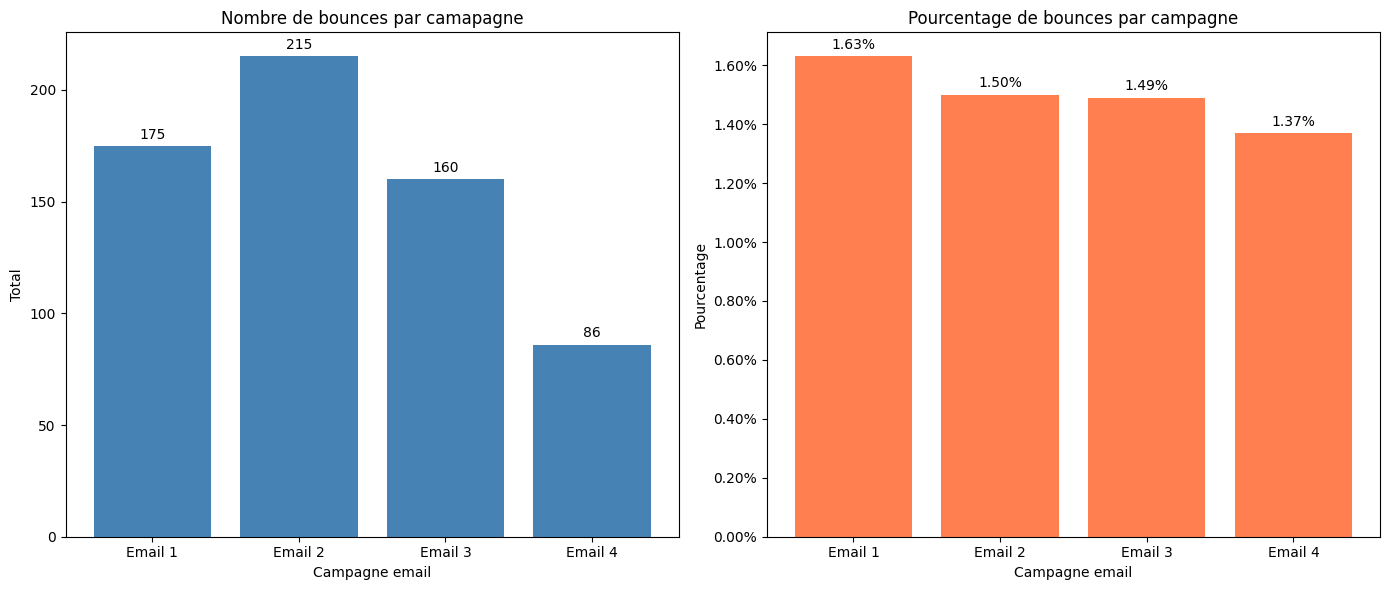

In [15]:
bounce_stats = bounce_summary.loc[
    bounce_summary["bounce_bool"] == 1, ["email_name", "count", "pct"]
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(bounce_stats["email_name"], bounce_stats["count"], color="steelblue")
ax1.set_title("Nombre de bounces par camapagne")
ax1.set_xlabel("Campagne email")
ax1.set_ylabel("Total")
ax1.bar_label(bars1, padding=3)


bars2 = ax2.bar(bounce_stats["email_name"], bounce_stats["pct"], color="coral")
ax2.set_title("Pourcentage de bounces par campagne")
ax2.set_xlabel("Campagne email")
ax2.set_ylabel("Pourcentage")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f%%"))

pct_labels = [f"{v:.2f}%" for v in bounce_stats["pct"]]
ax2.bar_label(bars2, labels=pct_labels, padding=3)


plt.tight_layout()
plt.show()

In [16]:
# Répartition des ouvertures par campagne
open_summary = (
    df_copy.groupby(["email_name", "open_bool"]).size().reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
open_summary["pct"] = open_summary.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
open_copy = (open_summary.copy().rename(
    columns={
        open_summary.columns[0]: "Campagne",
        open_summary.columns[1]: "Ouverture",
        open_summary.columns[2]: "Total",
        open_summary.columns[3]: "Pct",
    })
    .style
    .format({"Pct": "{:.2f}"}) 
    .hide(axis='index') 
)


file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_open_summary.png"
dfi.export(open_copy, file_path, table_conversion="matplotlib")


print("Répartition des ouvertures par campagne :")
open_summary

Répartition des ouvertures par campagne :


,email_name,open_bool,count,pct
0,Email 1,0,1611,14.99
1,Email 1,1,9139,85.01
2,Email 2,0,1762,12.30
3,Email 2,1,12563,87.70
4,Email 3,0,2433,22.65
5,Email 3,1,8308,77.35
6,Email 4,0,1448,23.09
7,Email 4,1,4822,76.91


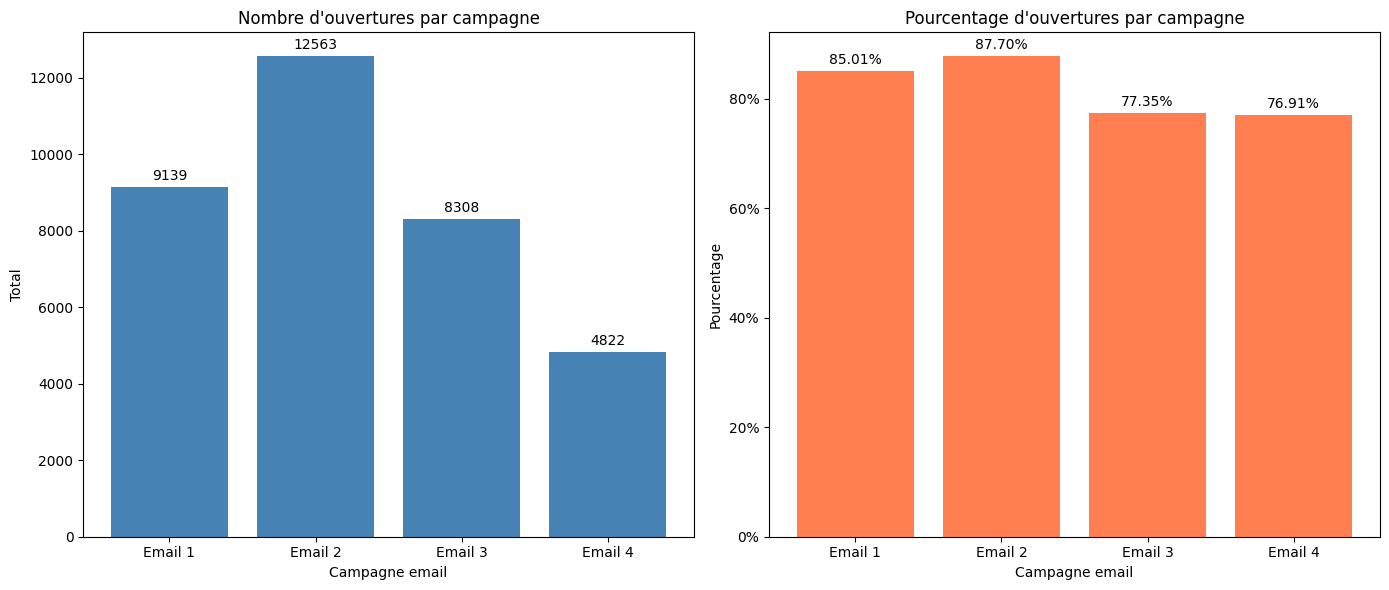

In [17]:
open_stats = open_summary.loc[
    open_summary["open_bool"] == 1, ["email_name", "count", "pct"]
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(open_stats["email_name"], open_stats["count"], color="steelblue")
ax1.set_title("Nombre d'ouvertures par campagne")
ax1.set_xlabel("Campagne email")
ax1.set_ylabel("Total")
ax1.bar_label(bars1, padding=3)


bars2 = ax2.bar(open_stats["email_name"], open_stats["pct"], color="coral")
ax2.set_title("Pourcentage d'ouvertures par campagne")
ax2.set_xlabel("Campagne email")
ax2.set_ylabel("Pourcentage")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))

pct_labels = [f"{v:.2f}%" for v in open_stats["pct"]]
ax2.bar_label(bars2, labels=pct_labels, padding=3)


plt.tight_layout()
plt.show()

In [18]:
# Répartition des taux de clic par campagne
click_summary = (
    df_copy.loc[df_copy["open_bool"] == 1]
    .groupby(["email_name", "click_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
click_summary["pct"] = click_summary.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
click_summary_copy = (click_summary.copy().rename(
    columns={
        click_summary.columns[0]: "Campagne",
        click_summary.columns[1]: "Click",
        click_summary.columns[2]: "Total",
        click_summary.columns[3]: "Pct",
    })
    .style
    .format({"Pct": "{:.2f}"}) 
    .hide(axis='index') 
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_click_summary.png"
dfi.export(click_summary_copy, file_path, table_conversion="matplotlib")


print("Répartition des taux de clic par campagne :")
click_summary

Répartition des taux de clic par campagne :


,email_name,click_bool,count,pct
0,Email 1,0,6608,61.47
1,Email 1,1,2531,23.54
2,Email 2,0,8506,59.38
3,Email 2,1,4057,28.32
4,Email 3,0,7369,68.61
5,Email 3,1,939,8.74
6,Email 4,0,3656,58.31
7,Email 4,1,1166,18.60


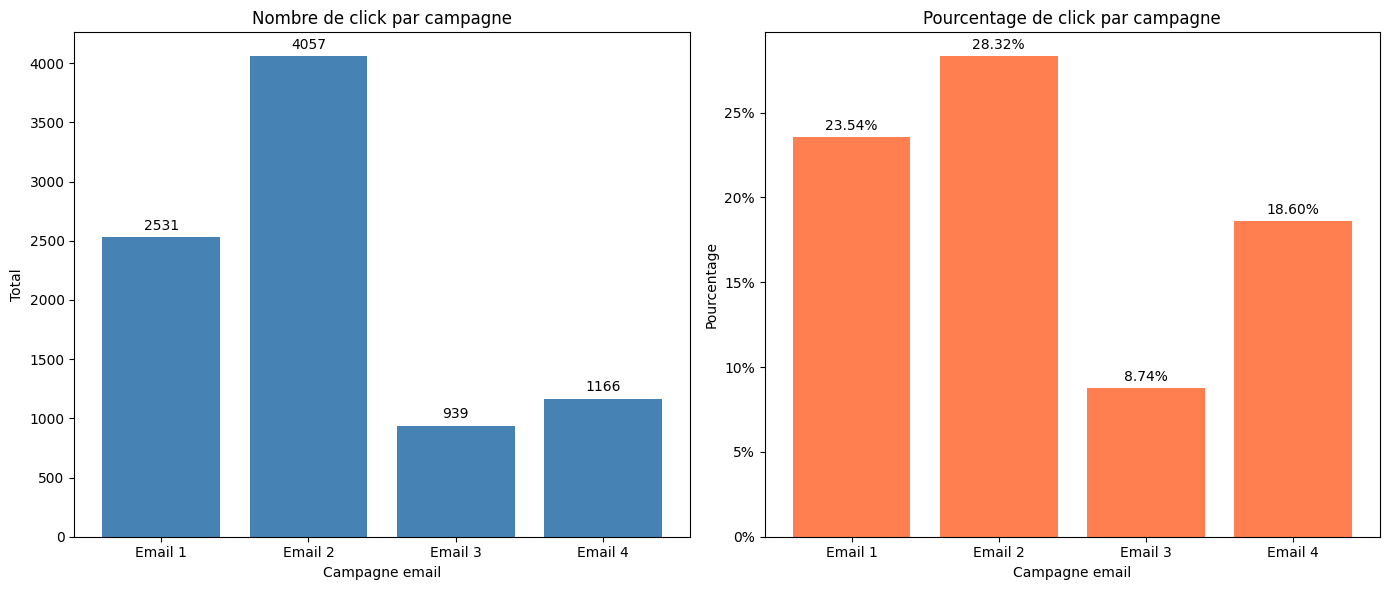

In [19]:
click_stats = click_summary.loc[
    click_summary["click_bool"] == 1, ["email_name", "count", "pct"]
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(click_stats["email_name"], click_stats["count"], color="steelblue")
ax1.set_title("Nombre de click par campagne")
ax1.set_xlabel("Campagne email")
ax1.set_ylabel("Total")
ax1.bar_label(bars1, padding=3)


bars2 = ax2.bar(click_stats["email_name"], click_stats["pct"], color="coral")
ax2.set_title("Pourcentage de click par campagne")
ax2.set_xlabel("Campagne email")
ax2.set_ylabel("Pourcentage")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))

pct_labels = [f"{v:.2f}%" for v in click_stats["pct"]]
ax2.bar_label(bars2, labels=pct_labels, padding=3)


plt.tight_layout()
plt.show()

In [20]:
# Répartition des transactions par campagne
transaction_summary = (
    df_copy.loc[df_copy["click_bool"] == 1]
    .groupby(["email_name", "transaction_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
transaction_summary["pct"] = transaction_summary.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
transaction_summary_copy = (transaction_summary.copy().rename(
    columns={
        transaction_summary.columns[0]: "Campagne",
        transaction_summary.columns[1]: "Transactions",
        transaction_summary.columns[2]: "Total",
        transaction_summary.columns[3]: "Pct",
    })
    .style
    .format({"Pct": "{:.2f}"}) 
    .hide(axis='index') 
)


file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_transaction_summary.png"
dfi.export(transaction_summary_copy, file_path, table_conversion="matplotlib")


print("Répartition des transactions par campagne :")
transaction_summary

Répartition des transactions par campagne :


,email_name,transaction_bool,count,pct
0,Email 1,0,2349,21.85
1,Email 1,1,182,1.69
2,Email 2,0,3519,24.57
3,Email 2,1,538,3.76
4,Email 3,0,815,7.59
5,Email 3,1,124,1.15
6,Email 4,0,1121,17.88
7,Email 4,1,45,0.72


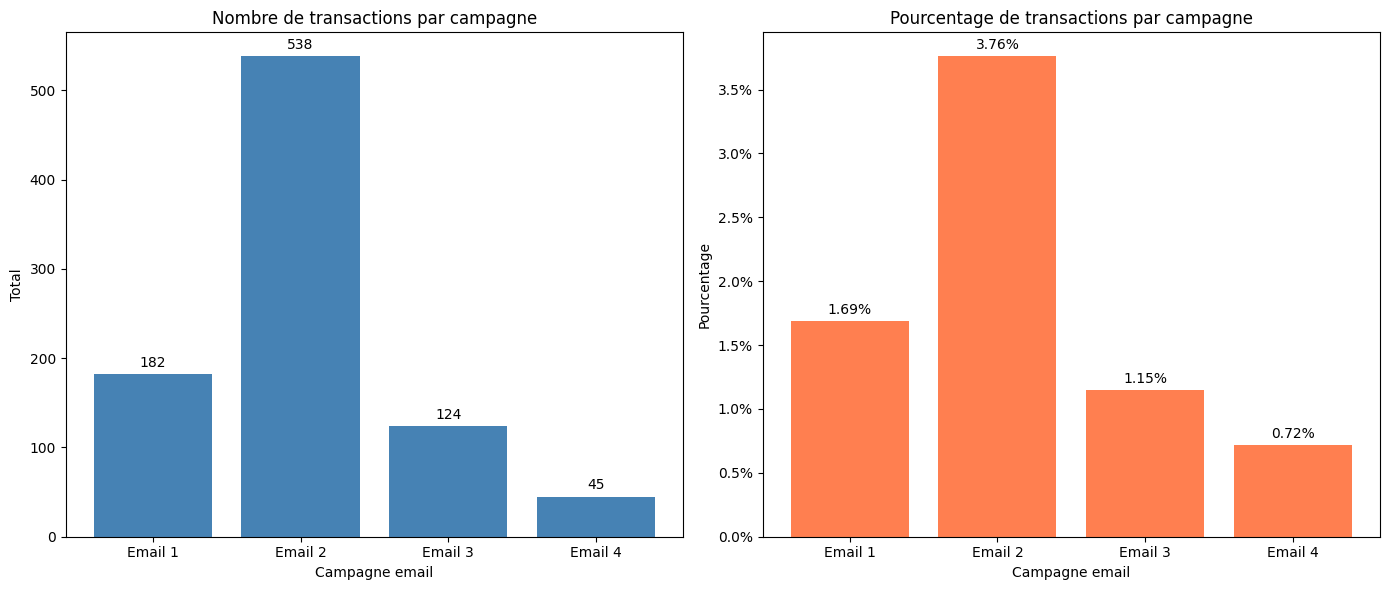

In [21]:
transaction_stats = transaction_summary.loc[
    transaction_summary["transaction_bool"] == 1, ["email_name", "count", "pct"]
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(
    transaction_stats["email_name"], transaction_stats["count"], color="steelblue"
)
ax1.set_title("Nombre de transactions par campagne")
ax1.set_xlabel("Campagne email")
ax1.set_ylabel("Total")
ax1.bar_label(bars1, padding=3)


bars2 = ax2.bar(
    transaction_stats["email_name"], transaction_stats["pct"], color="coral"
)
ax2.set_title("Pourcentage de transactions par campagne")
ax2.set_xlabel("Campagne email")
ax2.set_ylabel("Pourcentage")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f%%"))

pct_labels = [f"{v:.2f}%" for v in transaction_stats["pct"]]
ax2.bar_label(bars2, labels=pct_labels, padding=3)


plt.tight_layout()
plt.show()

In [22]:
# Revenue par campagne
earning_summary = round(
    df_copy.loc[df_copy["transaction_bool"] == 1]
    .groupby(["email_name"])["transaction_amount"]
    .sum()
    .reset_index(name="count")
)
earning_summary["count"] = (
    earning_summary["count"]
    .round()
    .astype(int)
    .map(lambda x: f"{x:,}".replace(",", " "))
)
earning_summary_copy = earning_summary.copy().rename(
    columns={
        earning_summary.columns[0]: "Campagne",
        earning_summary.columns[1]: "Revenu",
    }
).style.hide(axis='index')

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_earning_summary.png"
dfi.export(earning_summary_copy, file_path, table_conversion="matplotlib")


print("Répartition des revenus par campagne :")
earning_summary

Répartition des revenus par campagne :


,email_name,count
0,Email 1,177 967
1,Email 2,531 259
2,Email 3,123 289
3,Email 4,45 676


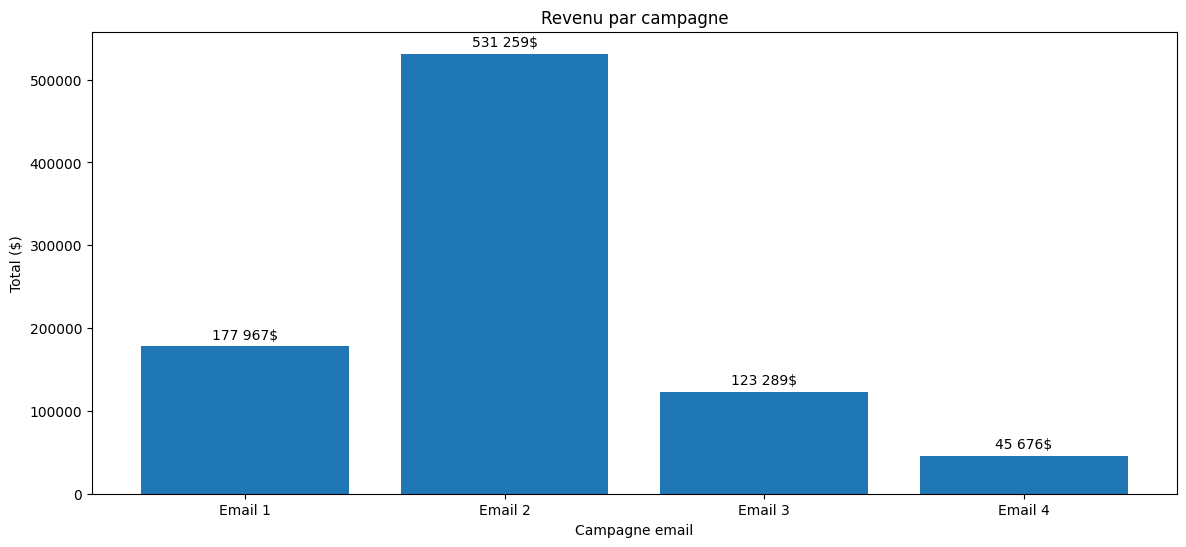

In [23]:
earning_summary["count_clean"] = (
    earning_summary["count"].str.replace(" ", "").astype(int)
)


fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(earning_summary["email_name"], earning_summary["count_clean"])
ax.set_title("Revenu par campagne")
ax.set_xlabel("Campagne email")
ax.set_ylabel("Total ($)")

labels_with_space = [
    f"{v:,.0f}$".replace(",", " ") for v in earning_summary["count_clean"]
]
ax.bar_label(bars, labels=labels_with_space, padding=3)

plt.show()


In [24]:
# Extraire les counts et pct pour chaque KPI
bounce_stats["Bounce Rate (total / %)"] = bounce_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

open_stats["Open Rate (total / %)"] = open_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

click_stats["Click Rate (total / %)"] = click_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

transaction_stats["Transaction Rate (total / %)"] = transaction_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

# Total d'emails envoyés par campagne
sent_count = df_copy["email_name"].value_counts().sort_index().reset_index()
sent_count.columns = ["email_name", "Envoyés"]

# Fusionner des colonnes
recap = (
    sent_count.merge(
        bounce_stats[["email_name", "Bounce Rate (total / %)"]],
        on="email_name",
        how="left",
    )
    .merge(
        open_stats[["email_name", "Open Rate (total / %)"]], on="email_name", how="left"
    )
    .merge(
        click_stats[["email_name", "Click Rate (total / %)"]],
        on="email_name",
        how="left",
    )
    .merge(
        transaction_stats[["email_name", "Transaction Rate (total / %)"]],
        on="email_name",
        how="left",
    )
    .merge(earning_summary[["email_name", "count"]], on="email_name", how="left")
)

recap = recap.rename(columns={"email_name": "Campagne", "count": "Earnings"})
recap_copy = recap.copy().style.hide(axis='index')

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_summary.png"
dfi.export(recap_copy, file_path, table_conversion="matplotlib")


print("Répartition des kpi par campagne :")
recap

Répartition des kpi par campagne :


,Campagne,Envoyés,Bounce Rate (total / %),Open Rate (total / %),Click Rate (total / %),Transaction Rate (total / %),Earnings
0,Email 1,10750,175 / 1.63%,9139 / 85.01%,2531 / 23.54%,182 / 1.69%,177 967
1,Email 2,14325,215 / 1.5%,12563 / 87.7%,4057 / 28.32%,538 / 3.76%,531 259
2,Email 3,10741,160 / 1.49%,8308 / 77.35%,939 / 8.74%,124 / 1.15%,123 289
3,Email 4,6270,86 / 1.37%,4822 / 76.91%,1166 / 18.6%,45 / 0.72%,45 676


## Analyse par date

### Année

In [25]:
df_grouped_y = df_copy.groupby(["email_name", "year"]).size().reset_index(name="count")


df_grouped_y_copy = (
    df_grouped_y
    .reset_index(drop=True)  
    .copy()  
    .rename(columns={
        df_grouped_y.columns[0]: "Campagne",
        df_grouped_y.columns[1]: "Année",
        df_grouped_y.columns[2]: "Total"
    })
).style.hide(axis='index')

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_total_mails_par_campagne_année.png"
dfi.export(df_grouped_y_copy, file_path, table_conversion="matplotlib")



print("Nombre d'emails envoyés par campagne par année :")
df_grouped_y

Nombre d'emails envoyés par campagne par année :


,email_name,year,count
0,Email 1,2019,2271
1,Email 1,2020,2345
2,Email 1,2021,2235
3,Email 1,2022,2363
4,Email 1,2023,1536
5,Email 2,2019,3090
6,Email 2,2020,3049
7,Email 2,2021,3008
8,Email 2,2022,3113
9,Email 2,2023,2065


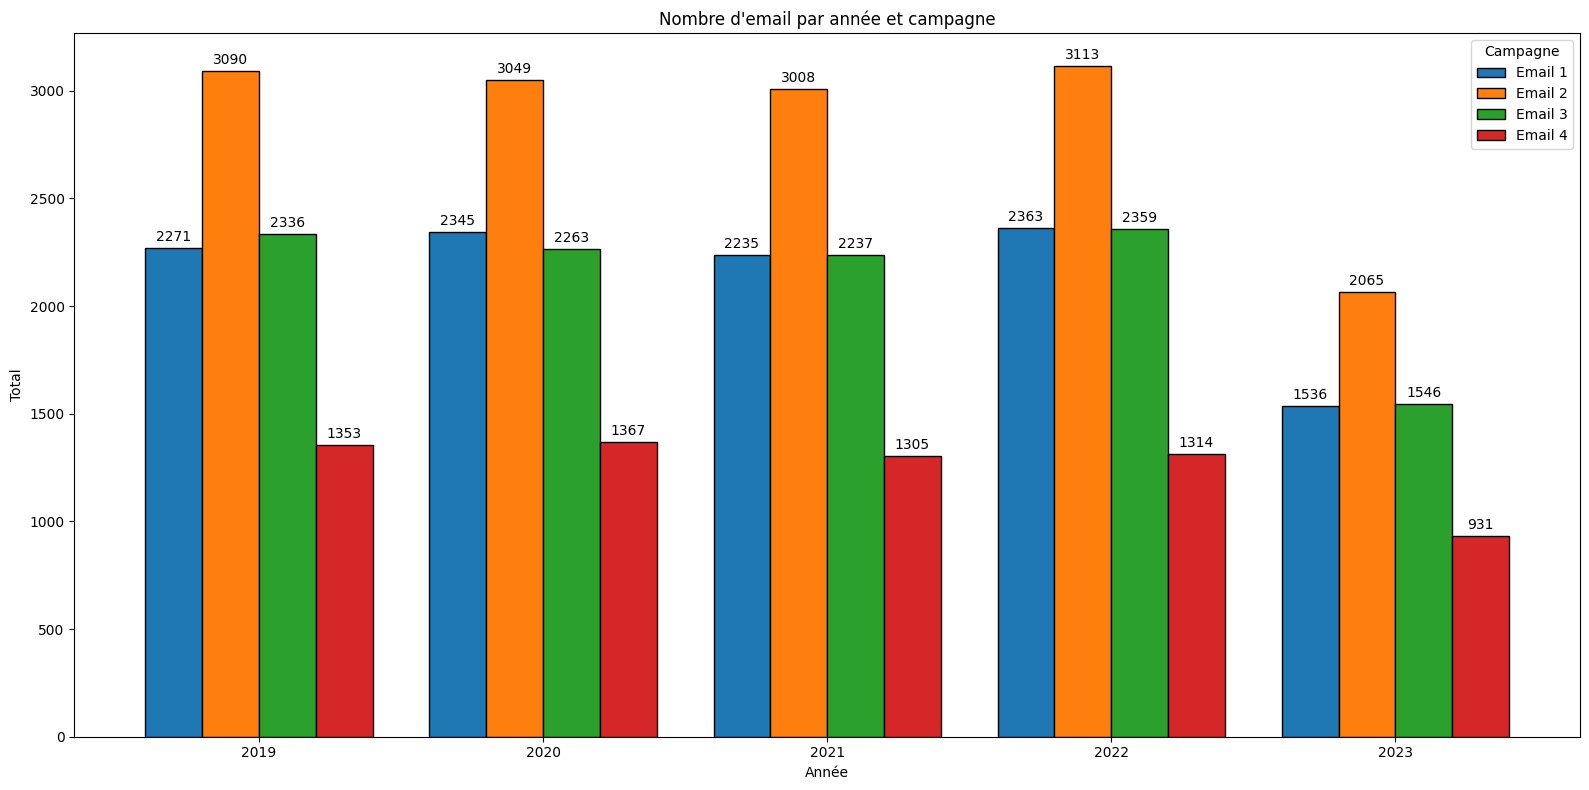

In [26]:
df_pivot = df_grouped_y.pivot(index="year", columns="email_name", values="count")


fig, ax = plt.subplots(figsize=(16, 8))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre d'email par année et campagne")
plt.xlabel("Année")
plt.ylabel("Total")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [27]:
# Répartition du bounce (taux de rejet) par campagne par année
bounce_summary_year = (
    df_copy.groupby(["email_name", "year", "bounce_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
bounce_summary_year["pct"] = bounce_summary_year.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)


bounce_summary_year_copy = (
    bounce_summary_year
    .reset_index(drop=True)  
    .copy()
    .rename(columns={
        bounce_summary_year.columns[0]: "Campagne",
        bounce_summary_year.columns[1]: "Année",
        bounce_summary_year.columns[2]: "Rebond",
        bounce_summary_year.columns[3]: "Total",
        bounce_summary_year.columns[4]: "Pct"
    })
    .style
    .format({"Pct": "{:.2f}"})  # formate la colonne Pct à 2 décimales
    .hide(axis='index')         # masque l'index
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_bounce_campagne_année.png"
dfi.export(bounce_summary_year_copy, file_path, table_conversion="matplotlib")


print("Répartition du bounce (taux de rejet) par campagne et par année :")
bounce_summary_year

Répartition du bounce (taux de rejet) par campagne et par année :


,email_name,year,bounce_bool,count,pct
0,Email 1,2019,0,2245,20.88
1,Email 1,2019,1,26,0.24
2,Email 1,2020,0,2310,21.49
3,Email 1,2020,1,35,0.33
4,Email 1,2021,0,2200,20.47
5,Email 1,2021,1,35,0.33
6,Email 1,2022,0,2314,21.53
7,Email 1,2022,1,49,0.46
8,Email 1,2023,0,1506,14.01
9,Email 1,2023,1,30,0.28


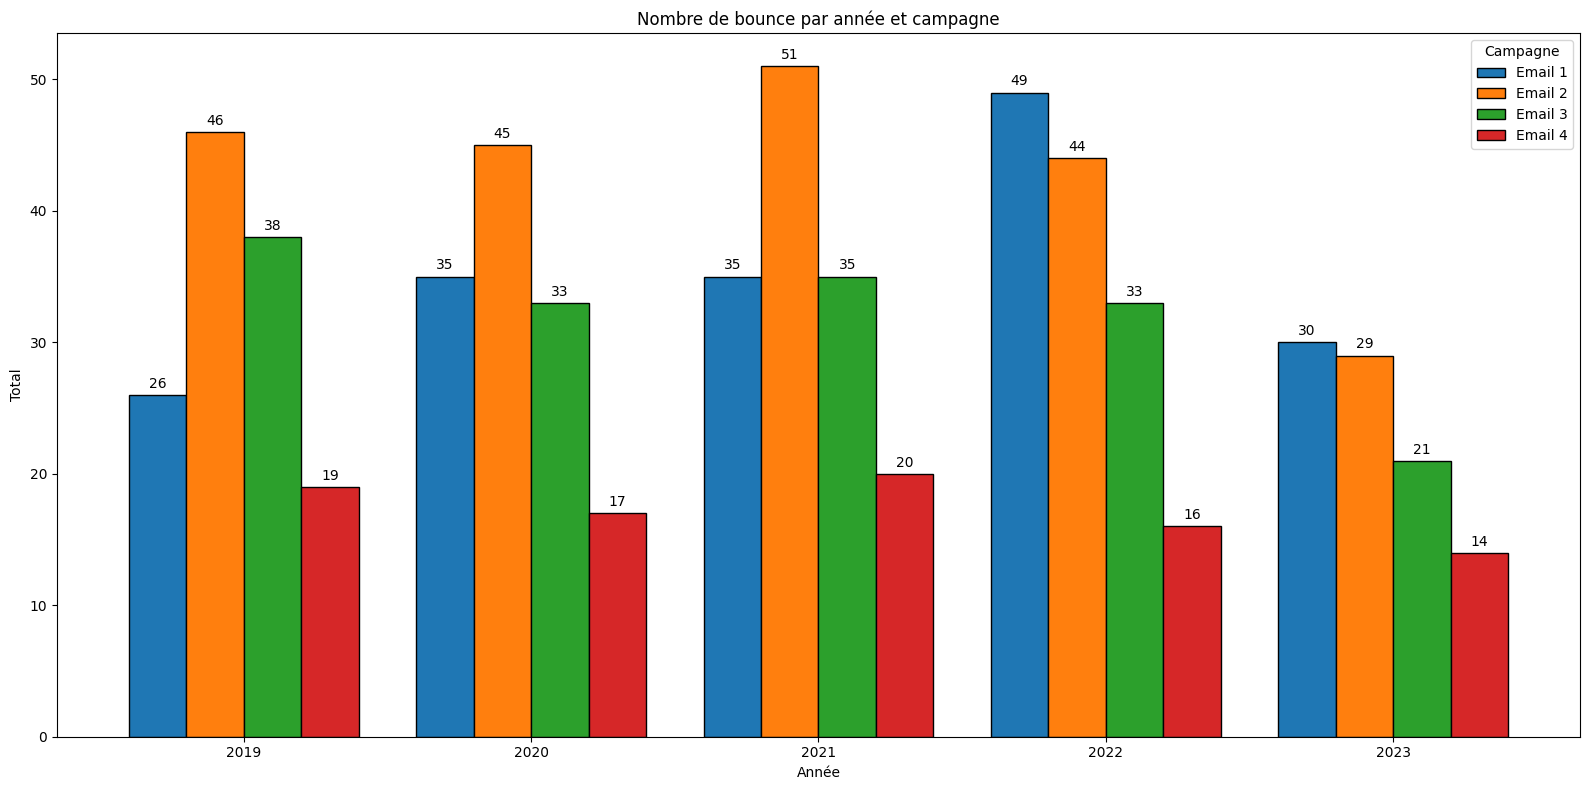

In [28]:
df_pivot = bounce_summary_year.loc[bounce_summary_year["bounce_bool"] == 1].pivot(
    index="year", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(16, 8))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de bounce par année et campagne")
plt.xlabel("Année")
plt.ylabel("Total")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [29]:
# Répartition des ouvertures par campagne par année
open_summary_year = (
    df_copy.groupby(["email_name", "year", "open_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year"]).size()
open_summary_year["pct"] = open_summary_year.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["year"]], 2
    ),
    axis=1,
)


open_summary_year_copy = (
    open_summary_year
    .reset_index(drop=True)  
    .copy()
    .rename(columns={
        open_summary_year.columns[0]: "Campagne",
        open_summary_year.columns[1]: "Année",
        open_summary_year.columns[2]: "Ouverture",
        open_summary_year.columns[3]: "Total",
        open_summary_year.columns[4]: "Pct"
    })
    .style
    .format({"Pct": "{:.2f}"})
    .hide(axis='index')
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_ouverture_campagne_année.png"
dfi.export(open_summary_year_copy, file_path, table_conversion="matplotlib")


print("Répartition des ouvertures par campagne et par année :")
open_summary_year

Répartition des ouvertures par campagne et par année :


,email_name,year,open_bool,count,pct
0,Email 1,2019,0,334,14.71
1,Email 1,2019,1,1937,85.29
2,Email 1,2020,0,356,15.18
3,Email 1,2020,1,1989,84.82
4,Email 1,2021,0,339,15.17
5,Email 1,2021,1,1896,84.83
6,Email 1,2022,0,380,16.08
7,Email 1,2022,1,1983,83.92
8,Email 1,2023,0,202,13.15
9,Email 1,2023,1,1334,86.85


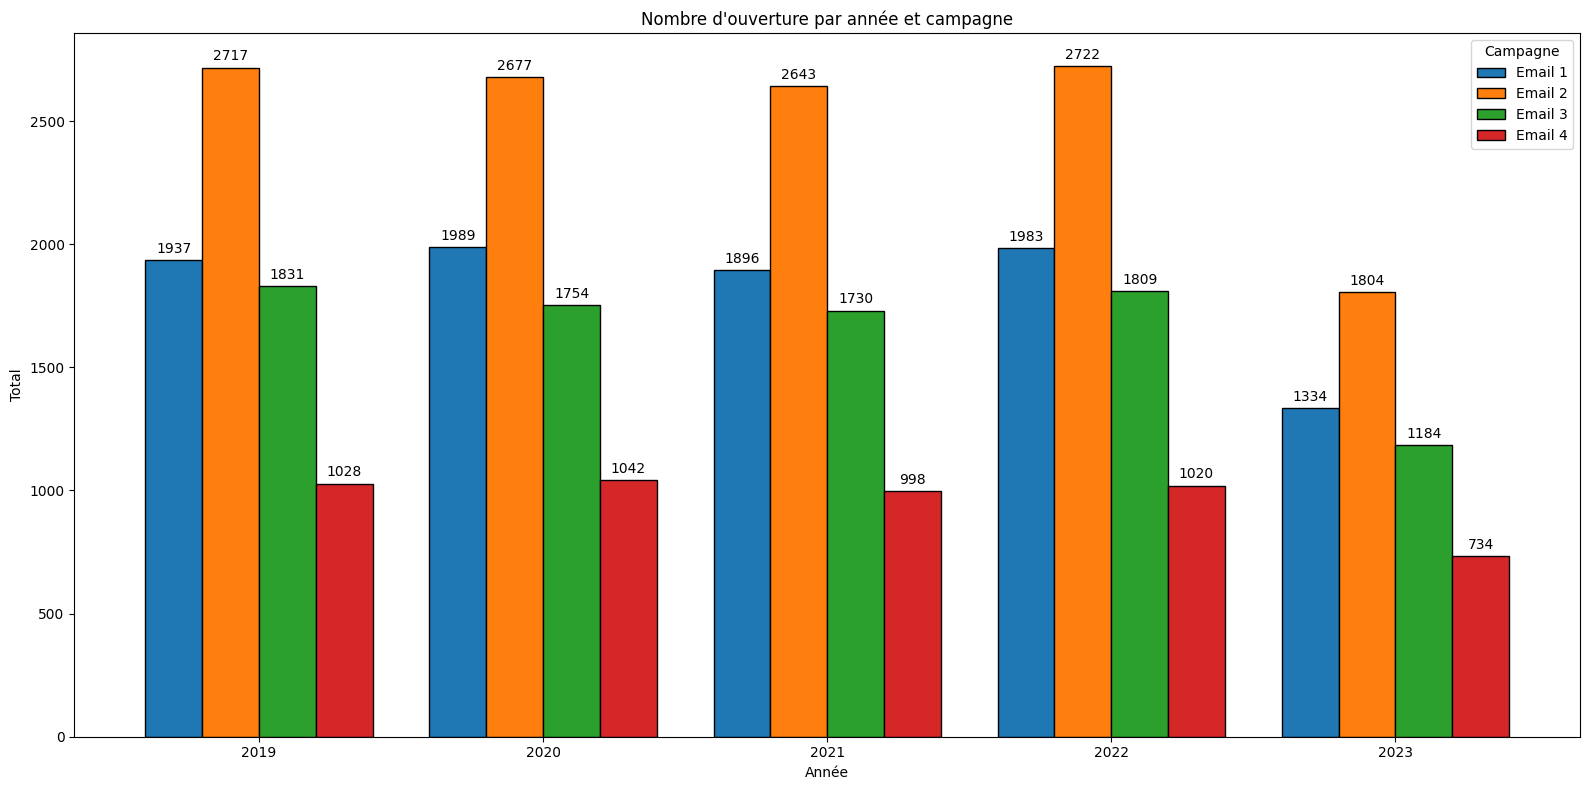

In [30]:
df_pivot = open_summary_year.loc[open_summary_year["open_bool"] == 1].pivot(
    index="year", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(16, 8))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre d'ouverture par année et campagne")
plt.xlabel("Année")
plt.ylabel("Total")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [31]:
# Répartition des taux de clic par campagne par année
click_summary_year = (
    df_copy.loc[df_copy["open_bool"] == 1]
    .groupby(["email_name", "year", "click_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year"]).size()
click_summary_year["pct"] = click_summary_year.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["year"]], 2
    ),
    axis=1,
)


click_summary_year_copy = (
    click_summary_year
    .reset_index(drop=True)  
    .copy()
    .rename(columns={
        click_summary_year.columns[0]: "Campagne",
        click_summary_year.columns[1]: "Année",
        click_summary_year.columns[2]: "Click",
        click_summary_year.columns[3]: "Total",
        click_summary_year.columns[4]: "Pct"
    })
    .style
    .format({"Pct": "{:.2f}"})
    .hide(axis='index')
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_click_campagne_année.png"
dfi.export(click_summary_year_copy, file_path, table_conversion="matplotlib")

print("Répartition des taux de clic par campagne et par année :")
click_summary_year

Répartition des taux de clic par campagne et par année :


,email_name,year,click_bool,count,pct
0,Email 1,2019,0,1386,61.03
1,Email 1,2019,1,551,24.26
2,Email 1,2020,0,1440,61.41
3,Email 1,2020,1,549,23.41
4,Email 1,2021,0,1373,61.43
5,Email 1,2021,1,523,23.40
6,Email 1,2022,0,1438,60.85
7,Email 1,2022,1,545,23.06
8,Email 1,2023,0,971,63.22
9,Email 1,2023,1,363,23.63


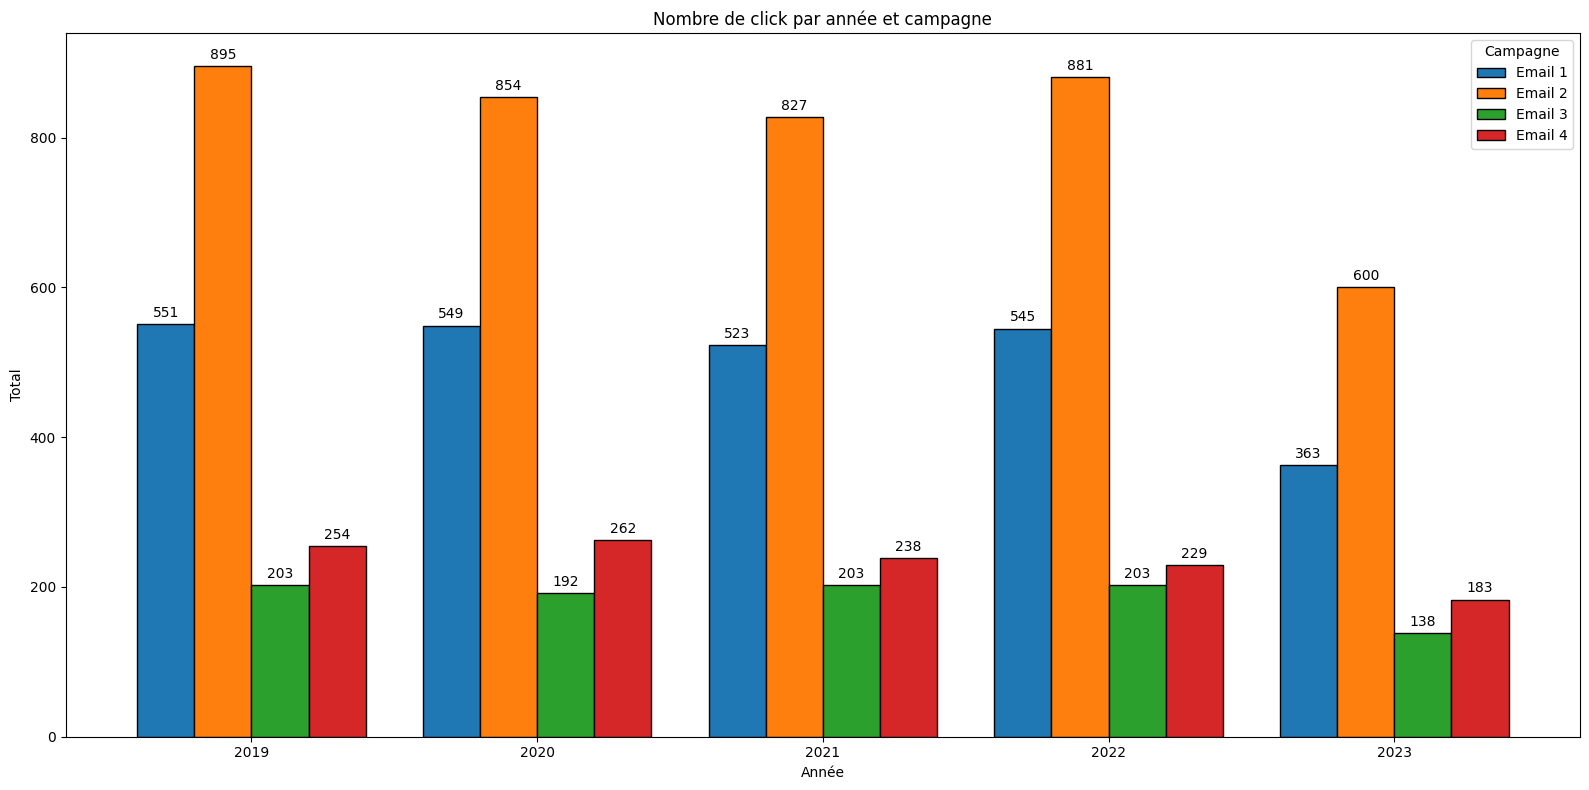

In [32]:
df_pivot = click_summary_year.loc[click_summary_year["click_bool"] == 1].pivot(
    index="year", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(16, 8))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de click par année et campagne")
plt.xlabel("Année")
plt.ylabel("Total")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [33]:
# Répartition des transactions par campagne
transaction_summary_year = (
    df_copy.loc[df_copy["click_bool"] == 1]
    .groupby(["email_name", "year", "transaction_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year"]).size()
transaction_summary_year["pct"] = transaction_summary_year.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["year"]], 2
    ),
    axis=1,
)


transaction_summary_year_copy = (
    transaction_summary_year
    .reset_index(drop=True)  
    .copy()
    .rename(columns={
        transaction_summary_year.columns[0]: "Campagne",
        transaction_summary_year.columns[1]: "Année",
        transaction_summary_year.columns[2]: "Click",
        transaction_summary_year.columns[3]: "Total",
        transaction_summary_year.columns[4]: "Pct"
    })
    .style
    .format({"Pct": "{:.2f}"})
    .hide(axis='index')
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_transaction_campagne_année.png"
dfi.export(transaction_summary_year_copy, file_path, table_conversion="matplotlib")


print("Répartition des transactions par campagne par année :")
transaction_summary_year

Répartition des transactions par campagne par année :


,email_name,year,transaction_bool,count,pct
0,Email 1,2019,0,509,22.41
1,Email 1,2019,1,42,1.85
2,Email 1,2020,0,516,22.00
3,Email 1,2020,1,33,1.41
4,Email 1,2021,0,488,21.83
5,Email 1,2021,1,35,1.57
6,Email 1,2022,0,498,21.07
7,Email 1,2022,1,47,1.99
8,Email 1,2023,0,338,22.01
9,Email 1,2023,1,25,1.63


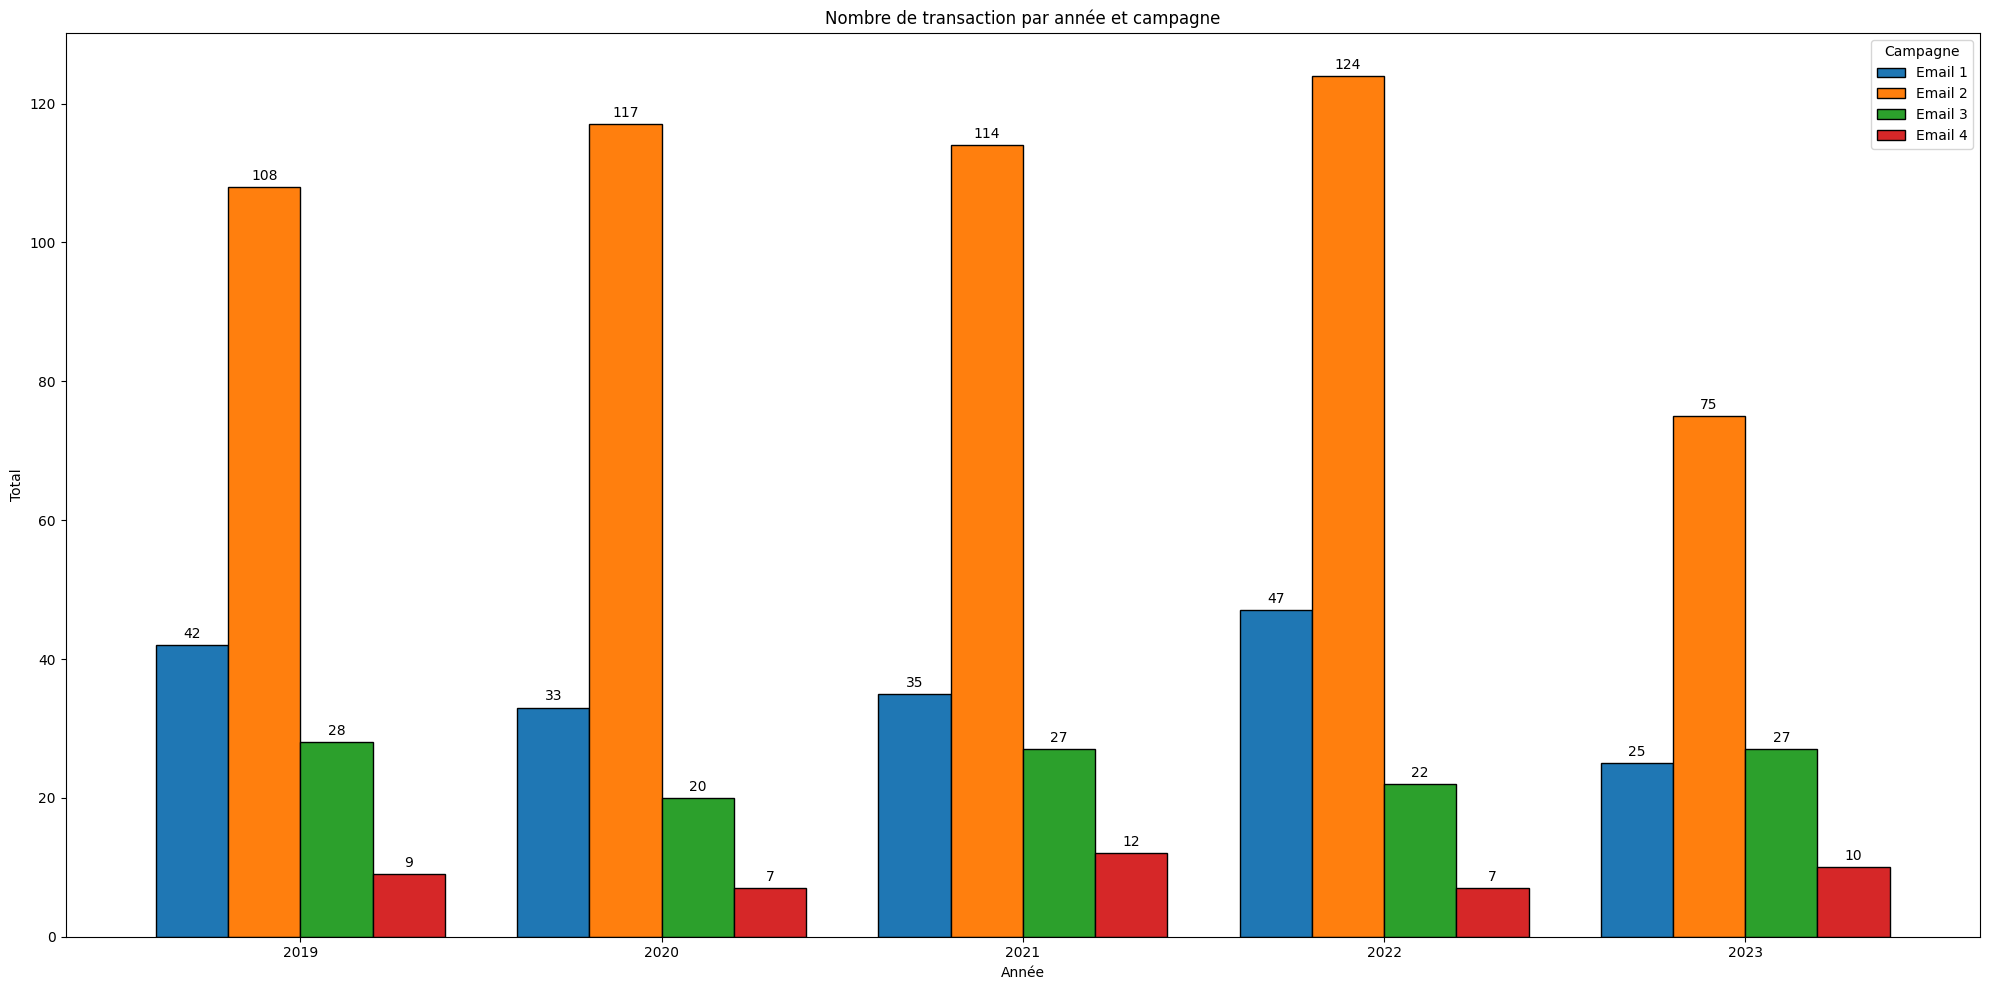

In [34]:
df_pivot = transaction_summary_year.loc[
    transaction_summary_year["transaction_bool"] == 1
].pivot(index="year", columns="email_name", values="count")


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de transaction par année et campagne")
plt.xlabel("Année")
plt.ylabel("Total")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [35]:
# Revenue par campagne par année
earning_summary_year = round(
    df_copy.loc[df_copy["transaction_bool"] == 1]
    .groupby(["email_name", "year"])["transaction_amount"]
    .sum()
    .reset_index(name="count")
)
earning_summary_year["count"] = (
    earning_summary_year["count"]
    .round()
    .astype(int)
    .map(lambda x: f"{x:,}".replace(",", " "))
)


earning_summary_year_copy = (
    earning_summary_year
    .reset_index(drop=True)  
    .copy()
    .rename(columns={
        earning_summary_year.columns[0]: "Campagne",
        earning_summary_year.columns[1]: "Année",
        earning_summary_year.columns[2]: "Revenu"
    })
    .style
    .hide(axis='index')
)

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_earning_campagne_année.png"
dfi.export(earning_summary_year_copy, file_path, table_conversion="matplotlib")


print("Répartition des revenus par campagne et  par année :")
earning_summary_year

Répartition des revenus par campagne et  par année :


,email_name,year,count
0,Email 1,2019,41 528
1,Email 1,2020,30 701
2,Email 1,2021,34 722
3,Email 1,2022,46 742
4,Email 1,2023,24 274
5,Email 2,2019,105 257
6,Email 2,2020,115 178
7,Email 2,2021,112 850
8,Email 2,2022,123 505
9,Email 2,2023,74 469


In [36]:
# Extraire les counts et pct pour chaque KPI
bounce_stats = bounce_summary_year.loc[
    bounce_summary_year["bounce_bool"] == 1, ["email_name", "year", "count", "pct"]
]
bounce_stats["Bounce Rate (total / %)"] = bounce_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

open_stats = open_summary_year.loc[
    open_summary_year["open_bool"] == 1, ["email_name", "year", "count", "pct"]
]
open_stats["Open Rate (total / %)"] = open_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

click_stats = click_summary_year.loc[
    click_summary_year["click_bool"] == 1, ["email_name", "year", "count", "pct"]
]
click_stats["Click Rate (total / %)"] = click_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

transaction_stats = transaction_summary_year.loc[
    transaction_summary_year["transaction_bool"] == 1,
    ["email_name", "year", "count", "pct"],
]
transaction_stats["Transaction Rate (total / %)"] = transaction_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)


# Total d'emails envoyés par campagne ET par année
sent_count = df_copy.groupby(["email_name", "year"]).size().reset_index(name="Envoyés")


# Fusionner toutes les colonnes
recap = (
    sent_count.merge(
        bounce_stats[["email_name", "year", "Bounce Rate (total / %)"]],
        on=["email_name", "year"],
        how="left",
    )
    .merge(
        open_stats[["email_name", "year", "Open Rate (total / %)"]],
        on=["email_name", "year"],
        how="left",
    )
    .merge(
        click_stats[["email_name", "year", "Click Rate (total / %)"]],
        on=["email_name", "year"],
        how="left",
    )
    .merge(
        transaction_stats[["email_name", "year", "Transaction Rate (total / %)"]],
        on=["email_name", "year"],
        how="left",
    )
    .merge(
        earning_summary_year[["email_name", "year", "count"]],
        on=["email_name", "year"],
        how="left",
    )
)

# Renommer les colonnes finales
recap = recap.rename(
    columns={"email_name": "Campagne", "year": "Année", "count": "Earnings"}
)

recap_copy = recap.copy().style.hide(axis='index')

file_path = r"C:/Users/fabie/Documents/Python_things/10_projets/Proj_5/graphique_tableau/tab_summary_campagne_année.png"
dfi.export(recap_copy, file_path, table_conversion="matplotlib")


print("Répartition des kpi par campagne et par année :")
recap


Répartition des kpi par campagne et par année :


,Campagne,Année,Envoyés,Bounce Rate (total / %),Open Rate (total / %),Click Rate (total / %),Transaction Rate (total / %),Earnings
0,Email 1,2019,2271,26 / 0.24%,1937 / 85.29%,551 / 24.26%,42 / 1.85%,41 528
1,Email 1,2020,2345,35 / 0.33%,1989 / 84.82%,549 / 23.41%,33 / 1.41%,30 701
2,Email 1,2021,2235,35 / 0.33%,1896 / 84.83%,523 / 23.4%,35 / 1.57%,34 722
3,Email 1,2022,2363,49 / 0.46%,1983 / 83.92%,545 / 23.06%,47 / 1.99%,46 742
4,Email 1,2023,1536,30 / 0.28%,1334 / 86.85%,363 / 23.63%,25 / 1.63%,24 274
5,Email 2,2019,3090,46 / 0.32%,2717 / 87.93%,895 / 28.96%,108 / 3.5%,105 257
6,Email 2,2020,3049,45 / 0.31%,2677 / 87.8%,854 / 28.01%,117 / 3.84%,115 178
7,Email 2,2021,3008,51 / 0.36%,2643 / 87.87%,827 / 27.49%,114 / 3.79%,112 850
8,Email 2,2022,3113,44 / 0.31%,2722 / 87.44%,881 / 28.3%,124 / 3.98%,123 505
9,Email 2,2023,2065,29 / 0.2%,1804 / 87.36%,600 / 29.06%,75 / 3.63%,74 469


### Mois

In [37]:
df_grouped_m = df_copy.groupby(["email_name", "month"]).size().reset_index(name="count")
df_grouped_m

,email_name,month,count
0,Email 1,1,998
1,Email 1,2,839
2,Email 1,3,944
3,Email 1,4,924
4,Email 1,5,1027
5,Email 1,6,951
6,Email 1,7,986
7,Email 1,8,1029
8,Email 1,9,709
9,Email 1,10,768


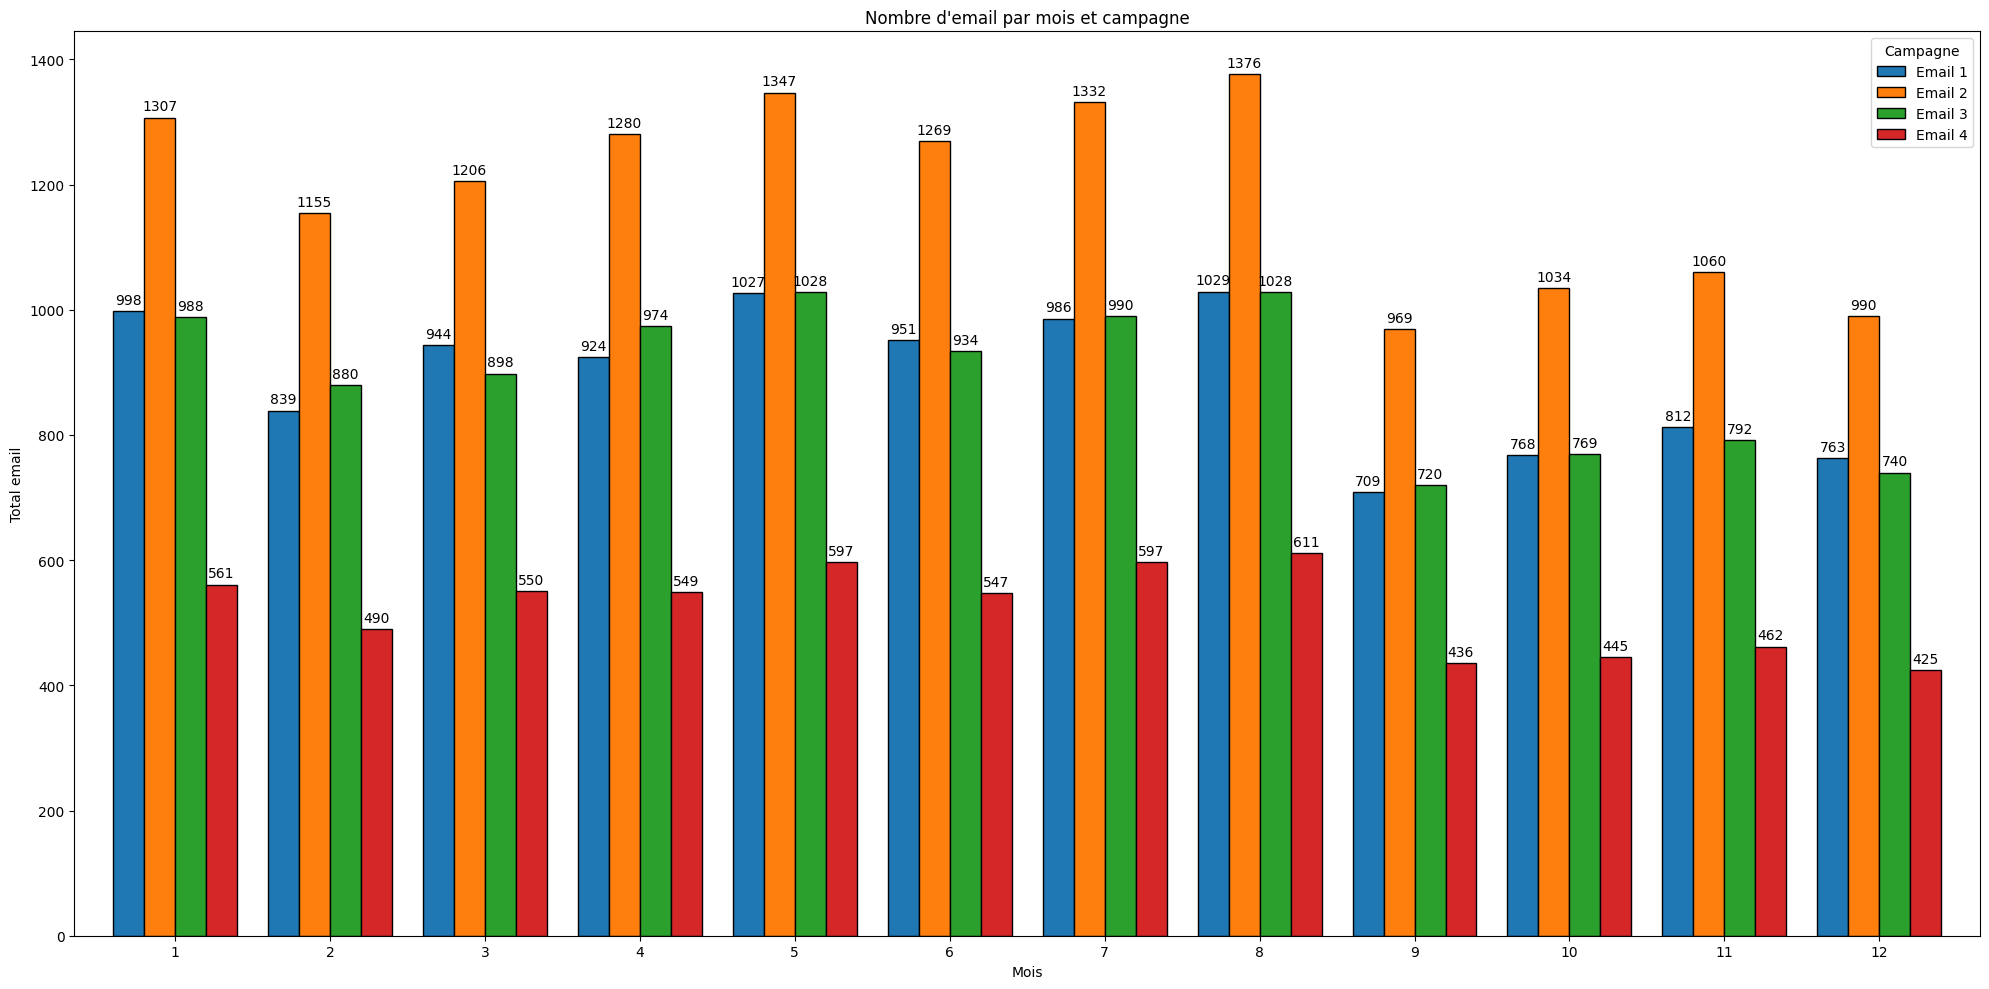

In [38]:
df_pivot = df_grouped_m.pivot(index="month", columns="email_name", values="count")


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre d'email par mois et campagne")
plt.xlabel("Mois")
plt.ylabel("Total email")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [39]:
# Répartition du bounce (taux de rejet) par campagne par mois
bounce_summary_month = (
    df_copy.groupby(["email_name", "month", "bounce_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
bounce_summary_month["pct"] = bounce_summary_month.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
print("Répartition du bounce (taux de rejet) par campagne et par mois :")
bounce_summary_month

Répartition du bounce (taux de rejet) par campagne et par mois :


,email_name,month,bounce_bool,count,pct
0,Email 1,1,0,982,9.13
1,Email 1,1,1,16,0.15
2,Email 1,2,0,824,7.67
3,Email 1,2,1,15,0.14
4,Email 1,3,0,929,8.64
...,...,...,...,...,...
91,Email 4,10,1,2,0.03
92,Email 4,11,0,457,7.29
93,Email 4,11,1,5,0.08
94,Email 4,12,0,422,6.73


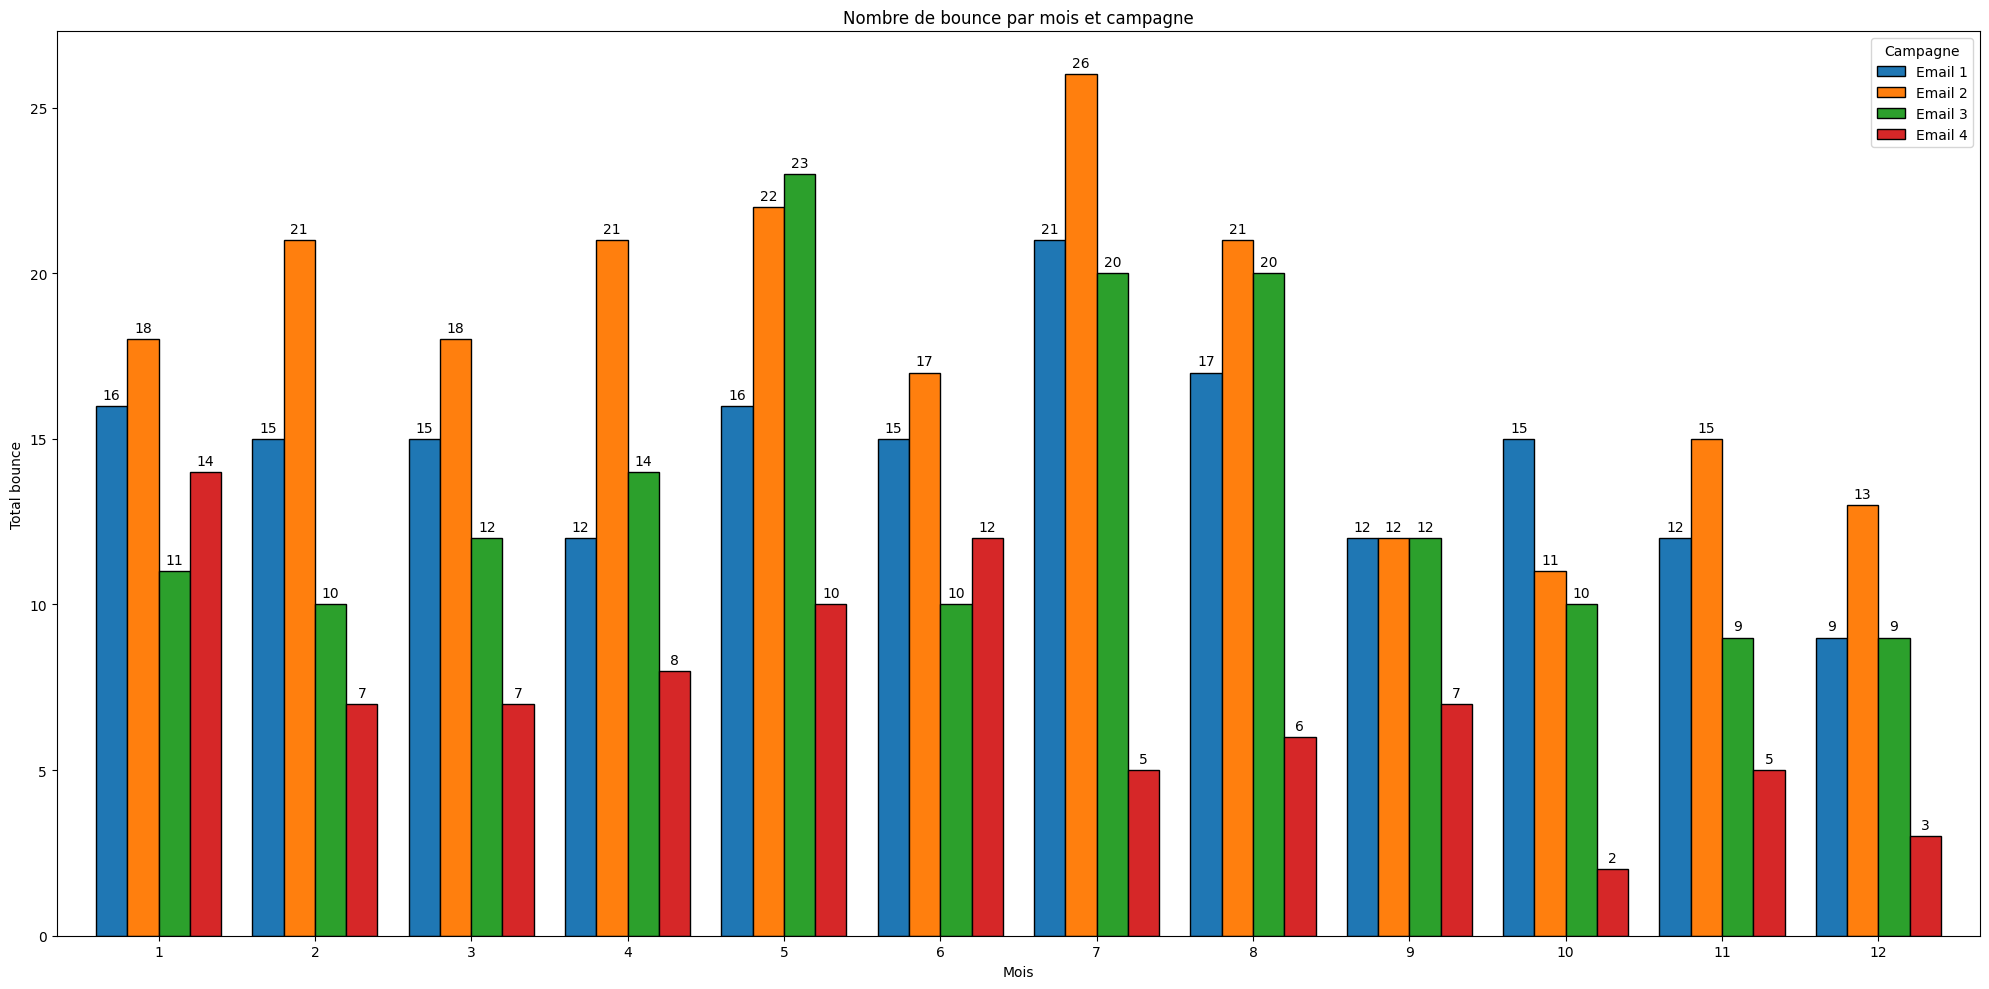

In [40]:
df_pivot = bounce_summary_month.loc[bounce_summary_month["bounce_bool"] == 1].pivot(
    index="month", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de bounce par mois et campagne")
plt.xlabel("Mois")
plt.ylabel("Total bounce")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [41]:
# Répartition des ouvertures par campagne par mois
open_summary_month = (
    df_copy.groupby(["email_name", "month", "open_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "month"]).size()
open_summary_month["pct"] = open_summary_month.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["month"]], 2
    ),
    axis=1,
)
print("Répartition des ouvertures par campagne et par mois :")
open_summary_month

Répartition des ouvertures par campagne et par mois :


,email_name,month,open_bool,count,pct
0,Email 1,1,0,146,14.63
1,Email 1,1,1,852,85.37
2,Email 1,2,0,117,13.95
3,Email 1,2,1,722,86.05
4,Email 1,3,0,143,15.15
...,...,...,...,...,...
91,Email 4,10,1,345,77.53
92,Email 4,11,0,109,23.59
93,Email 4,11,1,353,76.41
94,Email 4,12,0,104,24.47


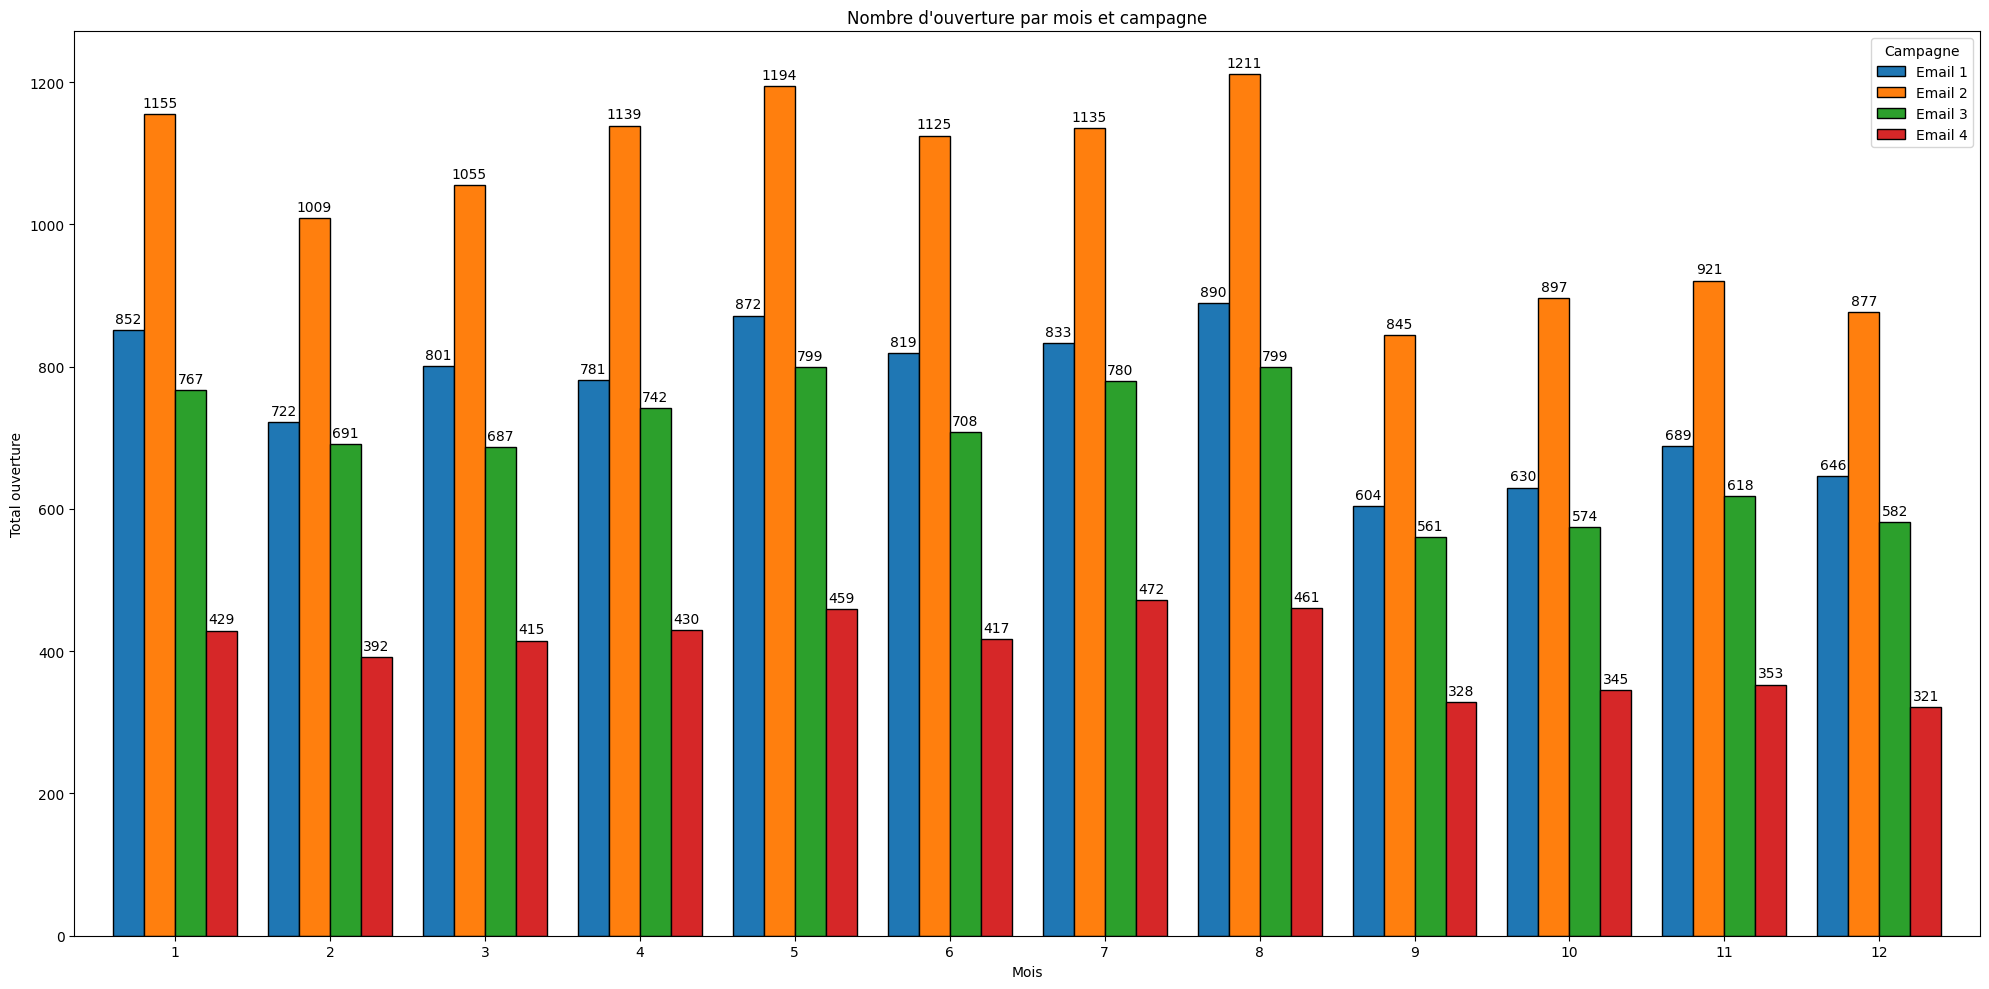

In [42]:
df_pivot = open_summary_month.loc[open_summary_month["open_bool"] == 1].pivot(
    index="month", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre d'ouverture par mois et campagne")
plt.xlabel("Mois")
plt.ylabel("Total ouverture")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [43]:
# Répartition des taux de clic par campagne par mois
click_summary_month = (
    df_copy.loc[df_copy["open_bool"] == 1]
    .groupby(["email_name", "month", "click_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "month"]).size()
click_summary_month["pct"] = click_summary_month.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["month"]], 2
    ),
    axis=1,
)

print("Répartition des taux de clic par campagne et par mois :")
click_summary_month

Répartition des taux de clic par campagne et par mois :


,email_name,month,click_bool,count,pct
0,Email 1,1,0,615,61.62
1,Email 1,1,1,237,23.75
2,Email 1,2,0,536,63.89
3,Email 1,2,1,186,22.17
4,Email 1,3,0,549,58.16
...,...,...,...,...,...
91,Email 4,10,1,69,15.51
92,Email 4,11,0,277,59.96
93,Email 4,11,1,76,16.45
94,Email 4,12,0,230,54.12


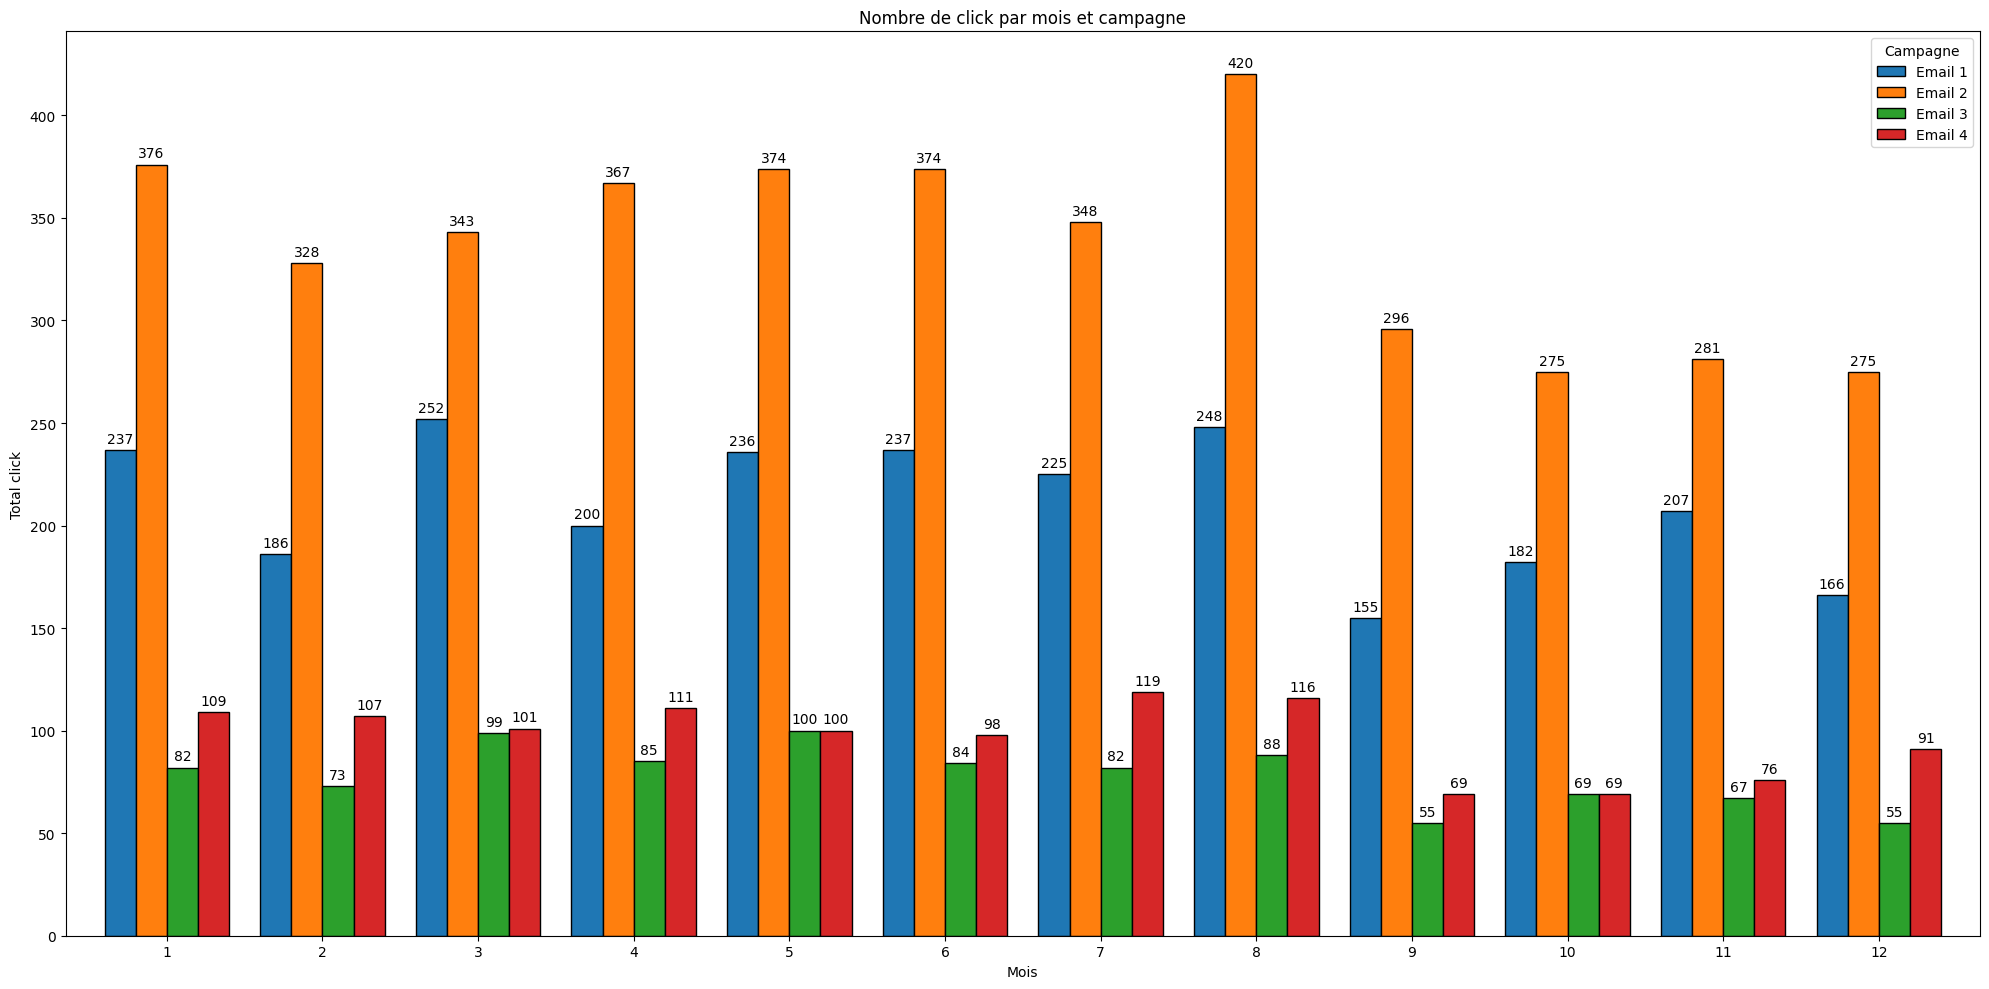

In [44]:
df_pivot = click_summary_month.loc[click_summary_month["click_bool"] == 1].pivot(
    index="month", columns="email_name", values="count"
)


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de click par mois et campagne")
plt.xlabel("Mois")
plt.ylabel("Total click")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [45]:
# Répartition des transactions par campagne par mois
transaction_summary_month = (
    df_copy.loc[df_copy["click_bool"] == 1]
    .groupby(["email_name", "month", "transaction_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "month"]).size()
transaction_summary_month["pct"] = transaction_summary_month.apply(
    lambda x: round(
        100 * x["count"] / total_per_campaign.loc[x["email_name"], x["month"]], 2
    ),
    axis=1,
)

print("Répartition des transactions par campagne et par mois :")
transaction_summary_month

Répartition des transactions par campagne et par mois :


,email_name,month,transaction_bool,count,pct
0,Email 1,1,0,227,22.75
1,Email 1,1,1,10,1.00
2,Email 1,2,0,174,20.74
3,Email 1,2,1,12,1.43
4,Email 1,3,0,236,25.00
...,...,...,...,...,...
90,Email 4,10,1,1,0.22
91,Email 4,11,0,68,14.72
92,Email 4,11,1,8,1.73
93,Email 4,12,0,84,19.76


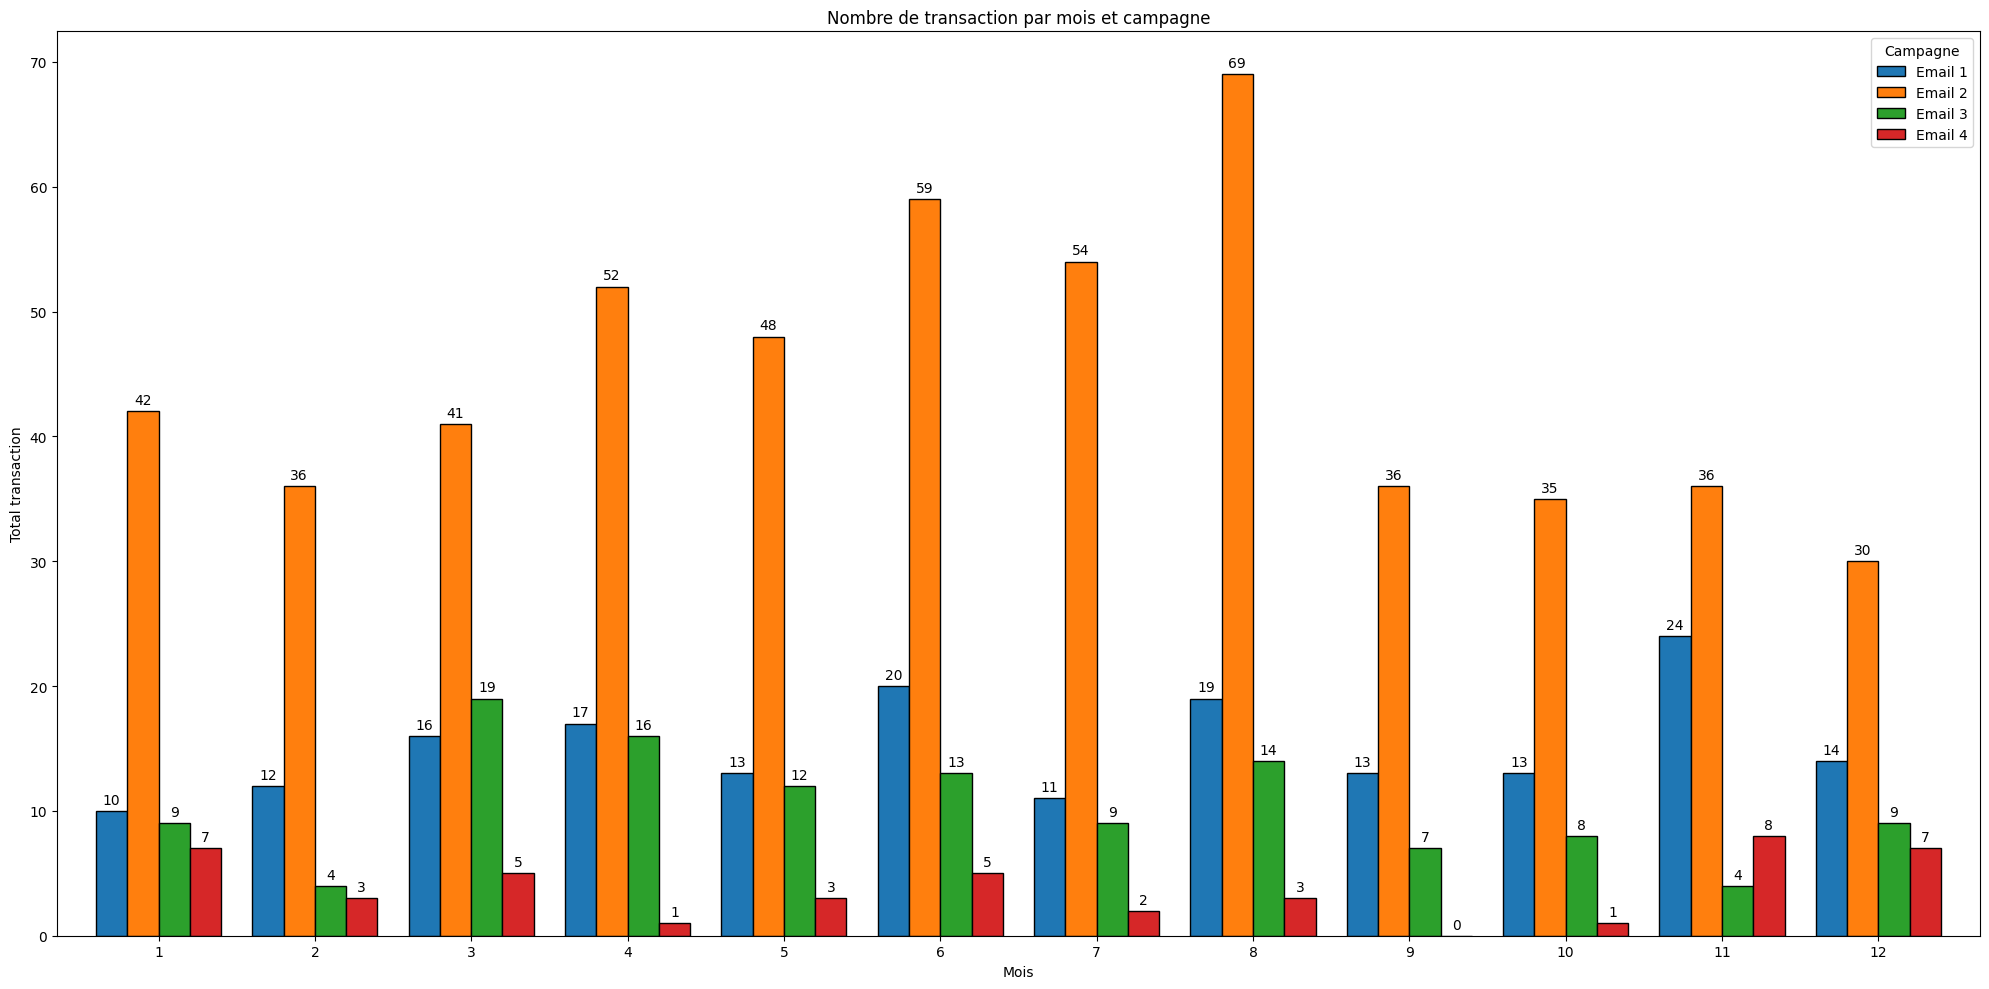

In [46]:
df_pivot = transaction_summary_month.loc[
    transaction_summary_month["transaction_bool"] == 1
].pivot(index="month", columns="email_name", values="count")


fig, ax = plt.subplots(figsize=(20, 10))

bars = df_pivot.plot(kind="bar", ax=ax, width=0.8, edgecolor="black")

plt.title("Nombre de transaction par mois et campagne")
plt.xlabel("Mois")
plt.ylabel("Total transaction")
plt.legend(title="Campagne")
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

In [47]:
# Revenue par campagne par mois
earning_summary_month = round(
    df_copy.loc[df_copy["transaction_bool"] == 1]
    .groupby(["email_name", "month"])["transaction_amount"]
    .sum()
    .reset_index(name="count")
)
earning_summary_month["count"] = (
    earning_summary_month["count"]
    .round()
    .astype(int)
    .map(lambda x: f"{x:,}".replace(",", " "))
)
earning_summary_month

,email_name,month,count
0,Email 1,1,9 047
1,Email 1,2,11 288
2,Email 1,3,16 227
3,Email 1,4,17 248
4,Email 1,5,12 287
5,Email 1,6,19 326
6,Email 1,7,11 832
7,Email 1,8,19 226
8,Email 1,9,12 548
9,Email 1,10,12 754


In [48]:
# Extraire les counts et pct pour chaque KPI
bounce_stats = bounce_summary_month.loc[
    bounce_summary_month["bounce_bool"] == 1, ["email_name", "month", "count", "pct"]
]
bounce_stats["Bounce Rate (total / %)"] = bounce_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

open_stats = open_summary_month.loc[
    open_summary_month["open_bool"] == 1, ["email_name", "month", "count", "pct"]
]
open_stats["Open Rate (total / %)"] = open_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

click_stats = click_summary_month.loc[
    click_summary_month["click_bool"] == 1, ["email_name", "month", "count", "pct"]
]
click_stats["Click Rate (total / %)"] = click_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

transaction_stats = transaction_summary_month.loc[
    transaction_summary_month["transaction_bool"] == 1,
    ["email_name", "month", "count", "pct"],
]
transaction_stats["Transaction Rate (total / %)"] = transaction_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)


# Total d'emails envoyés par campagne ET par année
sent_count = df_copy.groupby(["email_name", "month"]).size().reset_index(name="Envoyés")


# Fusionner toutes les colonnes
recap = (
    sent_count.merge(
        bounce_stats[["email_name", "month", "Bounce Rate (total / %)"]],
        on=["email_name", "month"],
        how="left",
    )
    .merge(
        open_stats[["email_name", "month", "Open Rate (total / %)"]],
        on=["email_name", "month"],
        how="left",
    )
    .merge(
        click_stats[["email_name", "month", "Click Rate (total / %)"]],
        on=["email_name", "month"],
        how="left",
    )
    .merge(
        transaction_stats[["email_name", "month", "Transaction Rate (total / %)"]],
        on=["email_name", "month"],
        how="left",
    )
    .merge(
        earning_summary_month[["email_name", "month", "count"]],
        on=["email_name", "month"],
        how="left",
    )
)

# Renommer les colonnes finales
recap_year = recap.rename(
    columns={"email_name": "Campagne", "month": "Mois", "count": "Earnings"}
)

recap_year = recap_year.fillna(
    {"Transaction Rate (total / %)": "0 / 0%", "Earnings": 0}
)

recap_year


,Campagne,Mois,Envoyés,Bounce Rate (total / %),Open Rate (total / %),Click Rate (total / %),Transaction Rate (total / %),Earnings
0,Email 1,1,998,16 / 0.15%,852 / 85.37%,237 / 23.75%,10 / 1.0%,9 047
1,Email 1,2,839,15 / 0.14%,722 / 86.05%,186 / 22.17%,12 / 1.43%,11 288
2,Email 1,3,944,15 / 0.14%,801 / 84.85%,252 / 26.69%,16 / 1.69%,16 227
3,Email 1,4,924,12 / 0.11%,781 / 84.52%,200 / 21.65%,17 / 1.84%,17 248
4,Email 1,5,1027,16 / 0.15%,872 / 84.91%,236 / 22.98%,13 / 1.27%,12 287
5,Email 1,6,951,15 / 0.14%,819 / 86.12%,237 / 24.92%,20 / 2.1%,19 326
6,Email 1,7,986,21 / 0.2%,833 / 84.48%,225 / 22.82%,11 / 1.12%,11 832
7,Email 1,8,1029,17 / 0.16%,890 / 86.49%,248 / 24.1%,19 / 1.85%,19 226
8,Email 1,9,709,12 / 0.11%,604 / 85.19%,155 / 21.86%,13 / 1.83%,12 548
9,Email 1,10,768,15 / 0.14%,630 / 82.03%,182 / 23.7%,13 / 1.69%,12 754


### Année-mois

In [49]:
df_copy.groupby(["email_name", "year", "month"]).size().reset_index(name="count")

,email_name,year,month,count
0,Email 1,2019,1,185
1,Email 1,2019,2,164
2,Email 1,2019,3,171
3,Email 1,2019,4,172
4,Email 1,2019,5,194
...,...,...,...,...
219,Email 4,2023,4,99
220,Email 4,2023,5,133
221,Email 4,2023,6,109
222,Email 4,2023,7,126


In [50]:
# Répartition du bounce (taux de rejet) par campagne par année-mois
bounce_summary_year_month = (
    df_copy.groupby(["email_name", "year", "month", "bounce_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby("email_name").size()
bounce_summary_year_month["pct"] = bounce_summary_year_month.apply(
    lambda x: round(100 * x["count"] / total_per_campaign.loc[x["email_name"]], 2),
    axis=1,
)
print("Répartition du bounce (taux de rejet) par campagne et par année-mois :")
bounce_summary_year_month

Répartition du bounce (taux de rejet) par campagne et par année-mois :


,email_name,year,month,bounce_bool,count,pct
0,Email 1,2019,1,0,183,1.70
1,Email 1,2019,1,1,2,0.02
2,Email 1,2019,2,0,159,1.48
3,Email 1,2019,2,1,5,0.05
4,Email 1,2019,3,0,168,1.56
...,...,...,...,...,...,...
430,Email 4,2023,6,1,2,0.03
431,Email 4,2023,7,0,125,1.99
432,Email 4,2023,7,1,1,0.02
433,Email 4,2023,8,0,123,1.96


In [51]:
# Répartition des ouvertures par campagne par année-mois
open_summary_year_month = (
    df_copy.groupby(["email_name", "year", "month", "open_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year", "month"]).size()
open_summary_year_month["pct"] = open_summary_year_month.apply(
    lambda x: round(
        100
        * x["count"]
        / total_per_campaign.loc[x["email_name"], x["year"], x["month"]],
        2,
    ),
    axis=1,
)
print("Répartition des ouvertures par campagne et par année-mois :")
open_summary_year_month

Répartition des ouvertures par campagne et par année-mois :


,email_name,year,month,open_bool,count,pct
0,Email 1,2019,1,0,21,11.35
1,Email 1,2019,1,1,164,88.65
2,Email 1,2019,2,0,33,20.12
3,Email 1,2019,2,1,131,79.88
4,Email 1,2019,3,0,20,11.70
...,...,...,...,...,...,...
443,Email 4,2023,6,1,85,77.98
444,Email 4,2023,7,0,22,17.46
445,Email 4,2023,7,1,104,82.54
446,Email 4,2023,8,0,28,22.58


In [52]:
# Répartition des taux de clic par campagne par année-mois
click_summary_year_month = (
    df_copy.loc[df_copy["open_bool"] == 1]
    .groupby(["email_name", "year", "month", "click_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year", "month"]).size()
click_summary_year_month["pct"] = click_summary_year_month.apply(
    lambda x: round(
        100
        * x["count"]
        / total_per_campaign.loc[x["email_name"], x["year"], x["month"]],
        2,
    ),
    axis=1,
)

print("Répartition des taux de clic par campagne et par année-mois :")
click_summary_year_month

Répartition des taux de clic par campagne et par année-mois :


,email_name,year,month,click_bool,count,pct
0,Email 1,2019,1,0,116,62.70
1,Email 1,2019,1,1,48,25.95
2,Email 1,2019,2,0,100,60.98
3,Email 1,2019,2,1,31,18.90
4,Email 1,2019,3,0,108,63.16
...,...,...,...,...,...,...
443,Email 4,2023,6,1,22,20.18
444,Email 4,2023,7,0,75,59.52
445,Email 4,2023,7,1,29,23.02
446,Email 4,2023,8,0,70,56.45


In [53]:
# Répartition des transactions par campagne par année-mois
transaction_summary_year_month = (
    df_copy.loc[df_copy["click_bool"] == 1]
    .groupby(["email_name", "year", "month", "transaction_bool"])
    .size()
    .reset_index(name="count")
)
total_per_campaign = df_copy.groupby(["email_name", "year", "month"]).size()
transaction_summary_year_month["pct"] = transaction_summary_year_month.apply(
    lambda x: round(
        100
        * x["count"]
        / total_per_campaign.loc[x["email_name"], x["year"], x["month"]],
        2,
    ),
    axis=1,
)

print("Répartition des transactions par campagne et par année-mois :")
transaction_summary_year_month

Répartition des transactions par campagne et par année-mois :


,email_name,year,month,transaction_bool,count,pct
0,Email 1,2019,1,0,46,24.86
1,Email 1,2019,1,1,2,1.08
2,Email 1,2019,2,0,31,18.90
3,Email 1,2019,3,0,41,23.98
4,Email 1,2019,3,1,2,1.17
...,...,...,...,...,...,...
403,Email 4,2023,6,0,19,17.43
404,Email 4,2023,6,1,3,2.75
405,Email 4,2023,7,0,28,22.22
406,Email 4,2023,7,1,1,0.79


In [54]:
# Revenue par campagne par année-mois
earning_summary_year_month = round(
    df_copy.loc[df_copy["transaction_bool"] == 1]
    .groupby(["email_name", "year", "month"])["transaction_amount"]
    .sum()
    .reset_index(name="count")
)
earning_summary_year_month["count"] = (
    earning_summary_year_month["count"]
    .round()
    .astype(int)
    .map(lambda x: f"{x:,}".replace(",", " "))
)
earning_summary_year_month

,email_name,year,month,count
0,Email 1,2019,1,1 796
1,Email 1,2019,3,2 103
2,Email 1,2019,4,3 058
3,Email 1,2019,5,3 967
4,Email 1,2019,6,5 741
...,...,...,...,...
179,Email 4,2023,1,3 070
180,Email 4,2023,2,1 252
181,Email 4,2023,5,2 559
182,Email 4,2023,6,2 758


In [55]:
# Extraire les counts et pct pour chaque KPI
bounce_stats = bounce_summary_year_month.loc[
    bounce_summary_year_month["bounce_bool"] == 1,
    ["email_name", "year", "month", "count", "pct"],
]
bounce_stats["Bounce Rate (total / %)"] = bounce_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

open_stats = open_summary_year_month.loc[
    open_summary_year_month["open_bool"] == 1,
    ["email_name", "year", "month", "count", "pct"],
]
open_stats["Open Rate (total / %)"] = open_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

click_stats = click_summary_year_month.loc[
    click_summary_year_month["click_bool"] == 1,
    ["email_name", "year", "month", "count", "pct"],
]
click_stats["Click Rate (total / %)"] = click_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)

transaction_stats = transaction_summary_year_month.loc[
    transaction_summary_year_month["transaction_bool"] == 1,
    ["email_name", "year", "month", "count", "pct"],
]
transaction_stats["Transaction Rate (total / %)"] = transaction_stats.apply(
    lambda x: f"{int(x['count'])} / {x['pct']}%", axis=1
)


# Total d'emails envoyés par campagne ET par année
sent_count = (
    df_copy.groupby(["email_name", "year", "month"]).size().reset_index(name="Envoyés")
)


# Fusionner toutes les colonnes
recap = (
    sent_count.merge(
        bounce_stats[["email_name", "year", "month", "Bounce Rate (total / %)"]],
        on=["email_name", "year", "month"],
        how="left",
    )
    .merge(
        open_stats[["email_name", "year", "month", "Open Rate (total / %)"]],
        on=["email_name", "year", "month"],
        how="left",
    )
    .merge(
        click_stats[["email_name", "year", "month", "Click Rate (total / %)"]],
        on=["email_name", "year", "month"],
        how="left",
    )
    .merge(
        transaction_stats[
            ["email_name", "year", "month", "Transaction Rate (total / %)"]
        ],
        on=["email_name", "year", "month"],
        how="left",
    )
    .merge(
        earning_summary_year_month[["email_name", "year", "month", "count"]],
        on=["email_name", "year", "month"],
        how="left",
    )
)

# Renommer les colonnes finales
recap_year_month = recap.rename(
    columns={
        "email_name": "Campagne",
        "year": "Année",
        "month": "Mois",
        "count": "Earnings",
    }
)

recap_year_month = recap_year_month.fillna(
    {"Transaction Rate (total / %)": "0 / 0%", "Earnings": 0}
)


recap_year_month


,Campagne,Année,Mois,Envoyés,Bounce Rate (total / %),Open Rate (total / %),Click Rate (total / %),Transaction Rate (total / %),Earnings
0,Email 1,2019,1,185,2 / 0.02%,164 / 88.65%,48 / 25.95%,2 / 1.08%,1 796
1,Email 1,2019,2,164,5 / 0.05%,131 / 79.88%,31 / 18.9%,0 / 0%,0
2,Email 1,2019,3,171,3 / 0.03%,151 / 88.3%,43 / 25.15%,2 / 1.17%,2 103
3,Email 1,2019,4,172,2 / 0.02%,141 / 81.98%,38 / 22.09%,3 / 1.74%,3 058
4,Email 1,2019,5,194,1 / 0.01%,167 / 86.08%,40 / 20.62%,4 / 2.06%,3 967
...,...,...,...,...,...,...,...,...,...
219,Email 4,2023,4,99,4 / 0.06%,74 / 74.75%,20 / 20.2%,0 / 0%,0
220,Email 4,2023,5,133,1 / 0.02%,106 / 79.7%,26 / 19.55%,2 / 1.5%,2 559
221,Email 4,2023,6,109,2 / 0.03%,85 / 77.98%,22 / 20.18%,3 / 2.75%,2 758
222,Email 4,2023,7,126,1 / 0.02%,104 / 82.54%,29 / 23.02%,1 / 0.79%,1 073


In [56]:
recap_year_month.loc[
    (recap_year_month["Année"] == 2019) & (recap_year_month["Campagne"] == "Email 1")
]

,Campagne,Année,Mois,Envoyés,Bounce Rate (total / %),Open Rate (total / %),Click Rate (total / %),Transaction Rate (total / %),Earnings
0,Email 1,2019,1,185,2 / 0.02%,164 / 88.65%,48 / 25.95%,2 / 1.08%,1 796
1,Email 1,2019,2,164,5 / 0.05%,131 / 79.88%,31 / 18.9%,0 / 0%,0
2,Email 1,2019,3,171,3 / 0.03%,151 / 88.3%,43 / 25.15%,2 / 1.17%,2 103
3,Email 1,2019,4,172,2 / 0.02%,141 / 81.98%,38 / 22.09%,3 / 1.74%,3 058
4,Email 1,2019,5,194,1 / 0.01%,167 / 86.08%,40 / 20.62%,4 / 2.06%,3 967
5,Email 1,2019,6,184,5 / 0.05%,158 / 85.87%,48 / 26.09%,6 / 3.26%,5 741
6,Email 1,2019,7,203,NaN,176 / 86.7%,53 / 26.11%,2 / 0.99%,2 606
7,Email 1,2019,8,201,2 / 0.02%,176 / 87.56%,54 / 26.87%,3 / 1.49%,2 529
8,Email 1,2019,9,179,2 / 0.02%,153 / 85.47%,45 / 25.14%,5 / 2.79%,4 757
9,Email 1,2019,10,201,2 / 0.02%,168 / 83.58%,52 / 25.87%,6 / 2.99%,5 965


## Analyse comportement client

### Ouverture

#### Jours

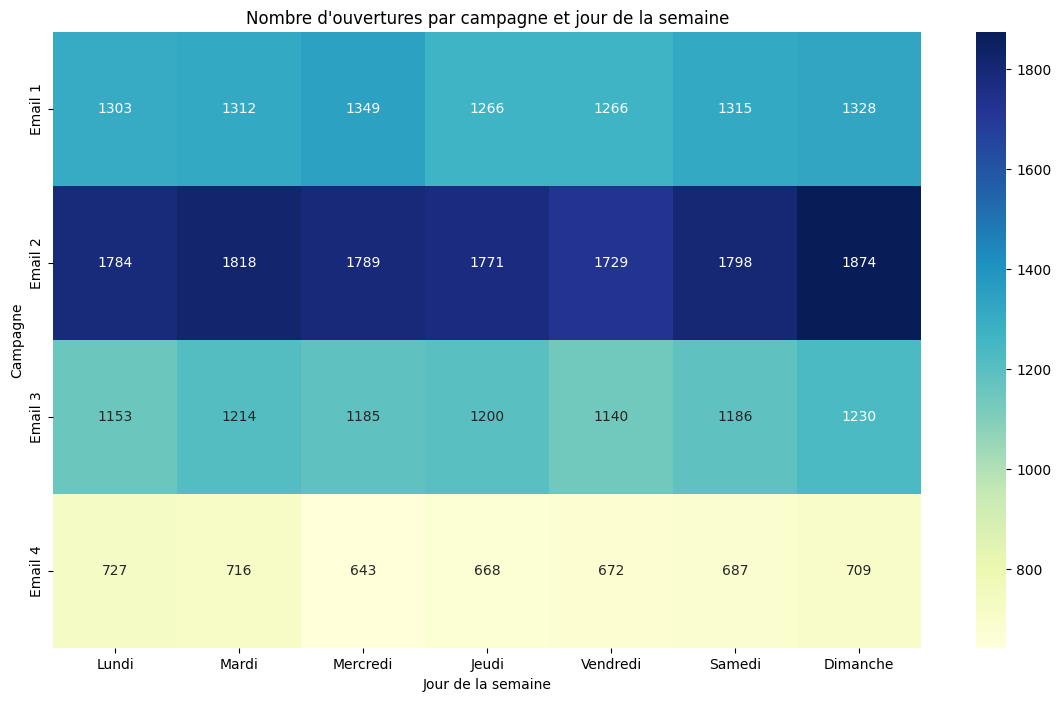

In [57]:
campagne_open_day = (
    df_copy.groupby(["email_name", "day_week", "open_bool"])
    .size()
    .reset_index(name="count")
)

campagne_open_day = campagne_open_day[campagne_open_day["open_bool"] == 1]

campagne_open_day = campagne_open_day.rename(
    columns={"email_name": "Campagne", "day_week": "Jours"}
)

pivoted = campagne_open_day.pivot(index="Campagne", columns="Jours", values="count")

jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_day = pivoted.reindex(columns=jours_fr)

pivoted_day = pivoted_day.fillna(0).astype(int)

pivoted_day["Meilleur jour"] = pivoted_day.idxmax(axis=1)

pivoted_day

heatmap_data = pivoted_day.drop(columns=["Meilleur jour"])

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")

plt.title("Nombre d'ouvertures par campagne et jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Campagne")
plt.show()

#### Année-jours

In [58]:
campagne_open_yday = (
    df_copy.groupby(["email_name", "year", "day_week", "open_bool"])
    .size()
    .reset_index(name="count")
)
campagne_open_yday = campagne_open_yday[campagne_open_yday["open_bool"] == 1]
campagne_open_yday = campagne_open_yday.rename(
    columns={"email_name": "Campagne", "day_week": "Jours", "year": "Année"}
)

pivoted_yday = campagne_open_yday.pivot_table(
    index=["Campagne", "Année"],
    columns="Jours",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_yday = pivoted_yday.reindex(columns=jours_fr)
pivoted_yday = pivoted_yday.astype(int)

pivoted_yday["Meilleur jour"] = pivoted_yday.idxmax(axis=1)

display(pivoted_yday)


Jours           Lundi  Mardi  Mercredi  Jeudi  Vendredi  Samedi  Dimanche  \
Campagne Année                                                              
Email 1  2019     252    312       286    279       258     286       264   
         2020     296    267       327    249       291     266       293   
         2021     254    273       263    252       282     288       284   
         2022     280    275       272    297       271     310       278   
         2023     221    185       201    189       164     165       209   
Email 2  2019     372    383       416    392       363     392       399   
         2020     383    390       369    358       398     380       399   
         2021     354    383       356    392       358     399       401   
         2022     392    390       377    367       395     409       392   
         2023     283    272       271    262       215     218       283   
Email 3  2019     236    261       281    280       236     279       258   
         2020     258    267       245    237       260     235       252   
         2021     217    240       227    266       248     264       268   
         2022     259    258       259    243       254     263       273   
         2023     183    188       173    174       142     145       179   
Email 4  2019     144    133       145    147       145     146       168   
         2020     159    160       134    128       164     148       149   
         2021     148    148       131    144       123     161       143   
         2022     151    157       138    153       150     139       132   
         2023     125    118        95     96        90      93       117   

Jours          Meilleur jour  
Campagne Année                
Email 1  2019          Mardi  
         2020       Mercredi  
         2021         Samedi  
         2022         Samedi  
         2023          Lundi  
Email 2  2019       Mercredi  
         2020       Dimanche  
         2021       Dimanche  
         2022         Samedi  
         2023          Lundi  
Email 3  2019       Mercredi  
         2020          Mardi  
         2021       Dimanche  
         2022       Dimanche  
         2023          Mardi  
Email 4  2019       Dimanche  
         2020       Vendredi  
         2021         Samedi  
         2022          Mardi  
         2023          Lundi

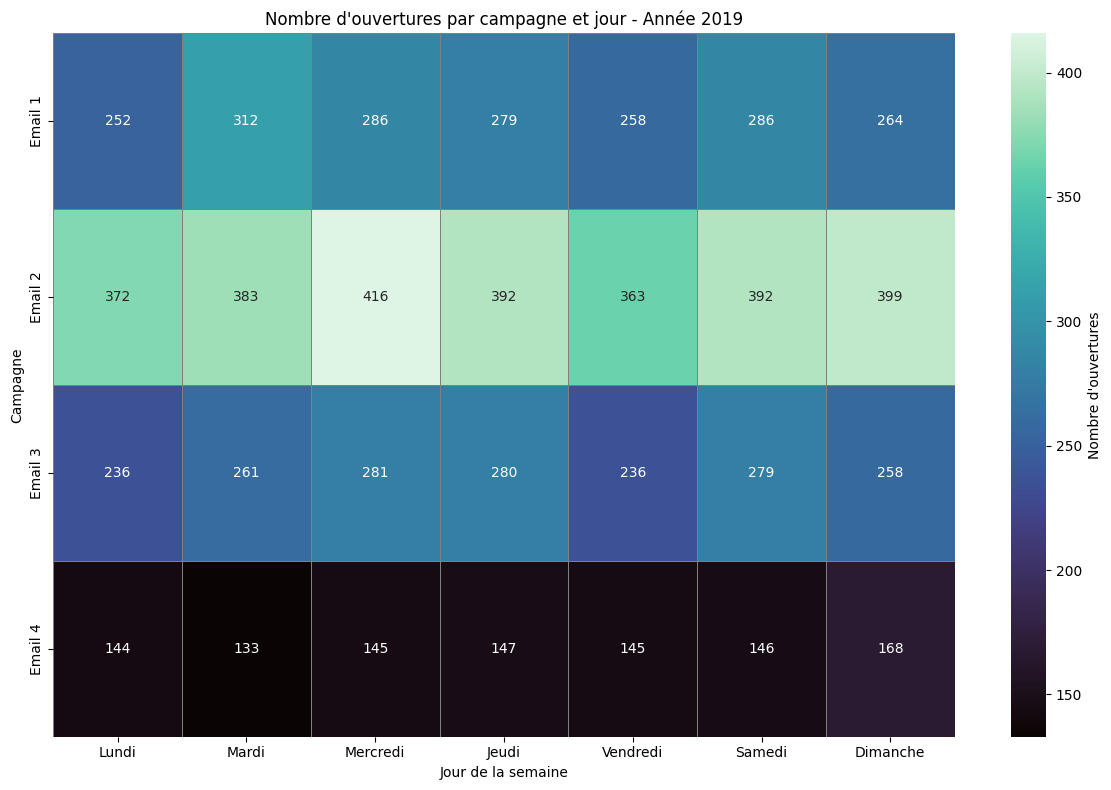

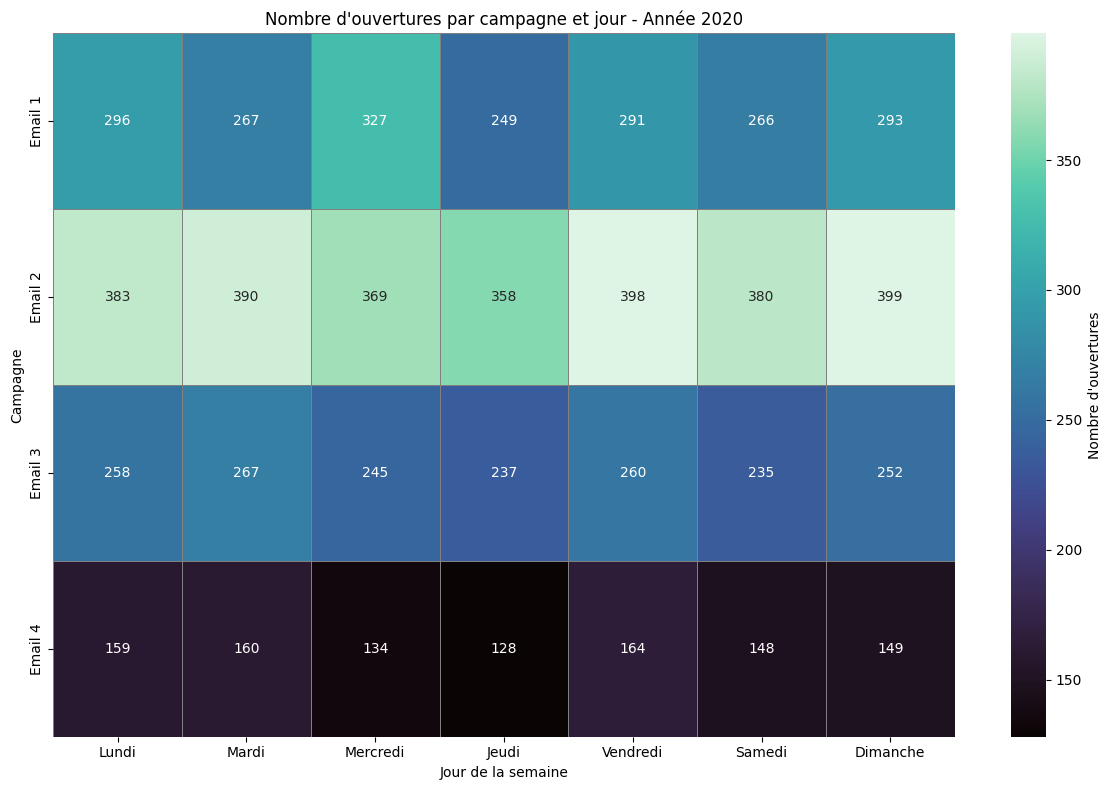

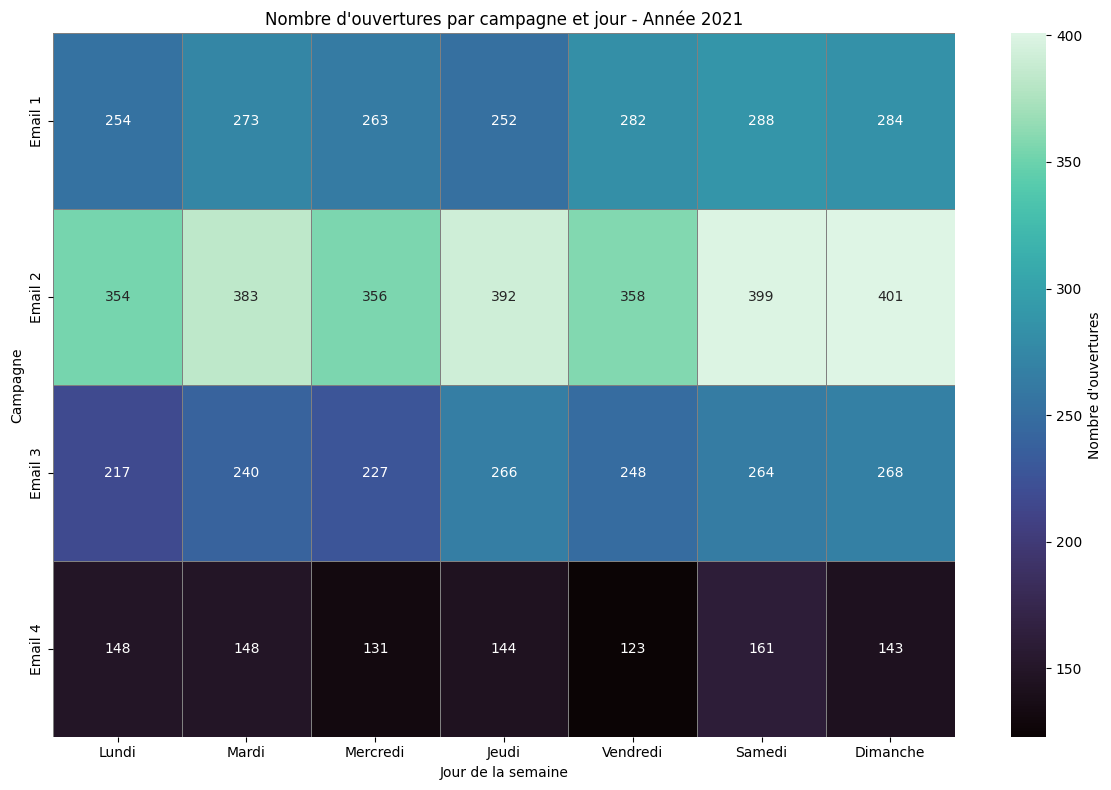

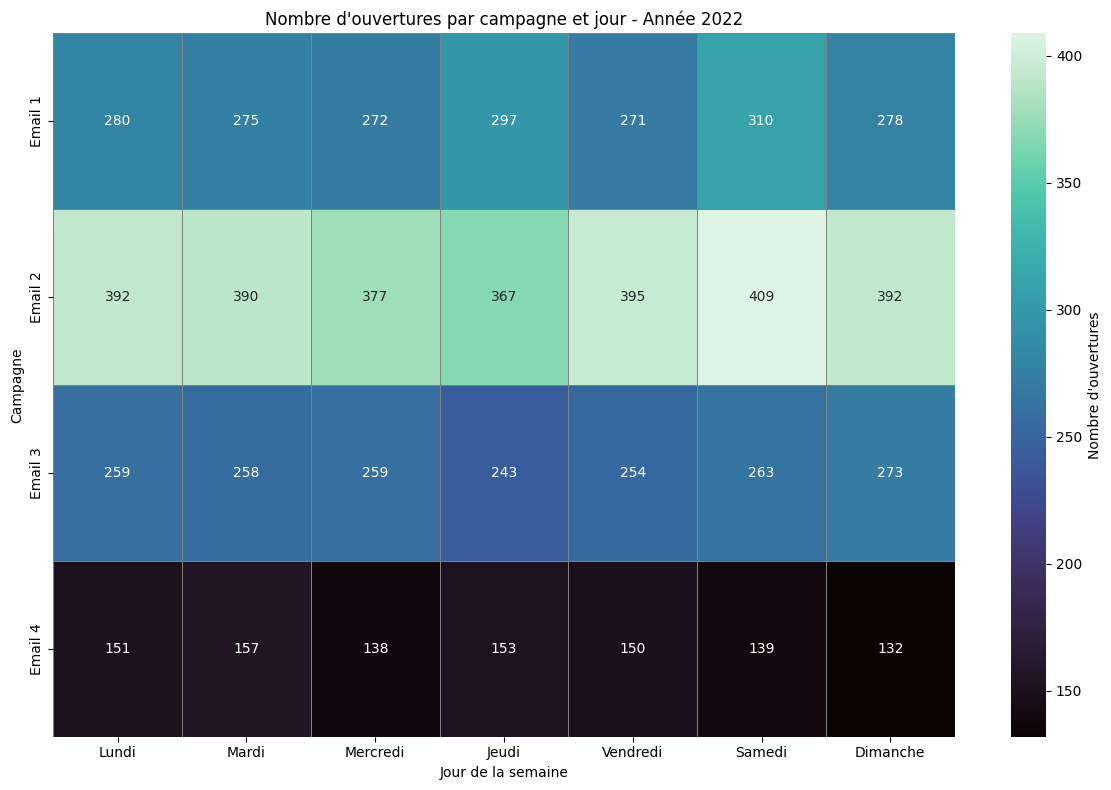

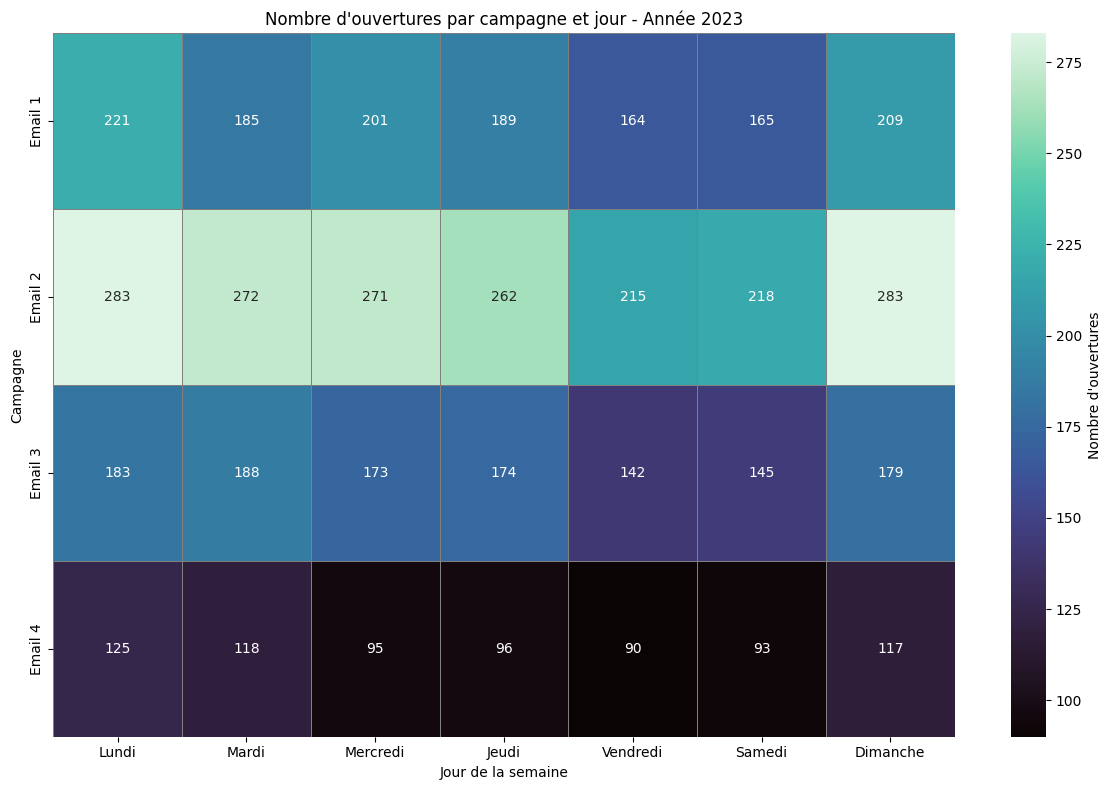

In [59]:
jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

# pivoted_yday est indexé par Campagne et Année (multi-index)
annees = pivoted_yday.index.get_level_values("Année").unique()

for annee in annees:
    subset = pivoted_yday.xs(annee, level="Année")

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        subset[jours_fr],
        annot=True,
        fmt="d",
        cmap="mako",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Nombre d'ouvertures"},
    )

    plt.title(f"Nombre d'ouvertures par campagne et jour - Année {annee}")
    plt.xlabel("Jour de la semaine")
    plt.ylabel("Campagne")
    plt.tight_layout()
    plt.show()

#### Année-mois-jours

In [60]:
campagne_open_ymd = (
    df_copy.groupby(["email_name", "year", "month", "day_week", "open_bool"])
    .size()
    .reset_index(name="count")
)
campagne_open_ymd = campagne_open_ymd[campagne_open_ymd["open_bool"] == 1]
campagne_open_ymd = campagne_open_ymd.rename(
    columns={
        "email_name": "Campagne",
        "day_week": "Jours",
        "year": "Année",
        "month": "Mois",
    }
)

pivoted_ymday = campagne_open_ymd.pivot_table(
    index=["Campagne", "Année", "Mois"],
    columns="Jours",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_ymday = pivoted_ymday.reindex(columns=jours_fr)
pivoted_ymday = pivoted_ymday.astype(int)

pivoted_ymday["Meilleur jour"] = pivoted_ymday.idxmax(axis=1)

display(pivoted_ymday)


Jours                Lundi  Mardi  Mercredi  Jeudi  Vendredi  Samedi  \
Campagne Année Mois                                                    
Email 1  2019  1        19     29        22     26        19      24   
               2        17     22        20     15        16      24   
               3        22     17        18     19        24      31   
               4        21     29        26     24        13      14   
               5        21     21        25     28        25      25   
...                    ...    ...       ...    ...       ...     ...   
Email 4  2023  4        10     11         8     10         9      14   
               5        18     24        13     11        12      13   
               6        13      8        10     12        15      12   
               7        25     13        11      8         8      19   
               8        14     19        11     13        10      11   

Jours                Dimanche Meilleur jour  
Campagne Année Mois                          
Email 1  2019  1           25         Mardi  
               2           17        Samedi  
               3           20        Samedi  
               4           14         Mardi  
               5           22         Jeudi  
...                       ...           ...  
Email 4  2023  4           12        Samedi  
               5           15         Mardi  
               6           15      Vendredi  
               7           20         Lundi  
               8           18         Mardi  

[224 rows x 8 columns]

In [ ]:
jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

annees = pivoted_ymday.index.get_level_values("Année").unique()
mois_list = pivoted_ymday.index.get_level_values("Mois").unique()

for annee in annees:
    for mois in mois_list:
        try:
            subset = pivoted_ymday.loc[(slice(None), annee, mois), jours_fr]
            campagnes = subset.index.get_level_values("Campagne")

            plt.figure(figsize=(12, 6))
            sns.heatmap(
                subset,
                annot=True,
                fmt="d",
                cmap="mako",
                linewidths=0.5,
                linecolor="gray",
                cbar_kws={"label": "Nombre d'ouvertures"},
            )
            plt.title(f"Nombre d'ouvertures par campagne et jour - {annee} / {mois}")
            plt.xlabel("Jour de la semaine")
            plt.ylabel("Campagne")

            plt.yticks(ticks=range(len(campagnes)), labels=campagnes, rotation=0)
            plt.xticks(rotation=45, ha="right")

            plt.tight_layout()
            plt.show()
        except KeyError:
            continue

In [62]:
pivoted_ymday[
    (pivoted_ymday.index.get_level_values("Campagne") == "Email 1")
    & (pivoted_ymday.index.get_level_values("Mois") == 1)
    & (pivoted_ymday.index.get_level_values("Année") == 2019)
]

,,Jours,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Samedi,Dimanche,Meilleur jour
Campagne,Année,Mois,,,,,,,,
Email 1,2019,1,19,29,22,26,19,24,25,Mardi


#### Année-mois-jours-période

In [63]:
campagne_open_ymd_p = (
    df_copy[df_copy["open_bool"] == 1]
    .groupby(["email_name", "year", "month", "day_week", "periode_open"])
    .size()
    .reset_index(name="count")
)

campagne_open_ymd_p = campagne_open_ymd_p.rename(
    columns={
        "email_name": "Campagne",
        "day_week": "Jours",
        "year": "Année",
        "month": "Mois",
        "periode_open": "Periode",
    }
)

pivoted_ymd_p = campagne_open_ymd_p.pivot_table(
    index=["Campagne", "Année", "Mois", "Jours"],
    columns="Periode",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

periodes_order = [
    "Nuit",
    "Petit matin",
    "Matin",
    "Midi",
    "Après-midi",
    "Soir",
    "Fin de soirée",
]
pivoted_ymd_p = pivoted_ymd_p.reindex(columns=periodes_order, fill_value=0)
pivoted_ymd_p = pivoted_ymd_p.astype(int)

pivoted_ymd_p["Meilleure période"] = pivoted_ymd_p.idxmax(axis=1)

display(pivoted_ymd_p)


Periode                       Nuit  Petit matin  Matin  Midi  Après-midi  \
Campagne Année Mois Jours                                                  
Email 1  2019  1    Dimanche     6            3      4     4           1   
                    Jeudi        3            1      6     4           5   
                    Lundi        6            1      0     0           5   
                    Mardi        8            2      4     4           5   
                    Mercredi     3            1      3     2           5   
...                            ...          ...    ...   ...         ...   
Email 4  2023  8    Lundi        3            1      3     1           5   
                    Mardi        6            1      2     2           2   
                    Mercredi     2            1      0     2           4   
                    Samedi       4            2      0     1           3   
                    Vendredi     3            0      0     1           1   

Periode                       Soir  Fin de soirée Meilleure période  
Campagne Année Mois Jours                                            
Email 1  2019  1    Dimanche     4              3              Nuit  
                    Jeudi        6              1             Matin  
                    Lundi        4              3              Nuit  
                    Mardi        1              5              Nuit  
                    Mercredi     5              3        Après-midi  
...                            ...            ...               ...  
Email 4  2023  8    Lundi        1              0        Après-midi  
                    Mardi        3              3              Nuit  
                    Mercredi     1              1        Après-midi  
                    Samedi       0              1              Nuit  
                    Vendredi     2              3              Nuit  

[1568 rows x 8 columns]

In [64]:
pivoted_ymd_p[
    (pivoted_ymd_p.index.get_level_values("Campagne") == "Email 4")
    & (pivoted_ymd_p.index.get_level_values("Mois") == 5)
]

Periode                       Nuit  Petit matin  Matin  Midi  Après-midi  \
Campagne Année Mois Jours                                                  
Email 4  2019  5    Dimanche     4            2      1     0           3   
                    Jeudi        0            0      1     1           3   
                    Lundi        5            0      0     0           1   
                    Mardi        5            1      1     2           1   
                    Mercredi     6            2      1     1           0   
                    Samedi       1            2      2     0           1   
                    Vendredi     3            0      1     3           1   
         2020  5    Dimanche     2            3      1     1           2   
                    Jeudi        4            4      3     2           0   
                    Lundi        7            1      2     3           2   
                    Mardi        3            1      3     1           0   
                    Mercredi     3            2      2     1           3   
                    Samedi       2            2      1     1           3   
                    Vendredi     1            2      2     3           2   
         2021  5    Dimanche     3            2      1     3           1   
                    Jeudi        4            2      2     1           3   
                    Lundi        0            1      2     0           4   
                    Mardi        1            0      4     4           2   
                    Mercredi     4            1      1     1           0   
                    Samedi       5            2      0     0           0   
                    Vendredi     2            1      2     0           3   
         2022  5    Dimanche     1            2      3     0           1   
                    Jeudi        1            3      2     1           0   
                    Lundi        3            0      3     1           3   
                    Mardi        6            0      1     0           0   
                    Mercredi     2            0      2     3           2   
                    Samedi       2            0      2     2           3   
                    Vendredi     3            1      1     3           2   
         2023  5    Dimanche     3            1      1     4           1   
                    Jeudi        3            3      1     0           2   
                    Lundi        3            4      1     3           1   
                    Mardi        5            4      2     2           3   
                    Mercredi     7            0      1     2           2   
                    Samedi       5            1      0     2           2   
                    Vendredi     3            3      2     0           2   

Periode                       Soir  Fin de soirée Meilleure période  
Campagne Année Mois Jours                                            
Email 4  2019  5    Dimanche     1              1              Nuit  
                    Jeudi        1              3        Après-midi  
                    Lundi        0              1              Nuit  
                    Mardi        2              0              Nuit  
                    Mercredi     3              3              Nuit  
                    Samedi       0              1       Petit matin  
                    Vendredi     2              3              Nuit  
         2020  5    Dimanche     4              3              Soir  
                    Jeudi        2              1              Nuit  
                    Lundi        1              1              Nuit  
                    Mardi        1              1              Nuit  
                    Mercredi     0              2              Nuit  
                    Samedi       1              2        Après-midi  
                    Vendredi     1              2              Midi  
         2021  5    Dimanche     1              2              Nuit

### Click

#### Jours

In [65]:
campagne_click_d = (
    df_copy[df_copy["click_bool"] == 1]
    .groupby(["email_name", "day_week", "periode_open"])
    .size()
    .reset_index(name="count")
)

campagne_click_d = campagne_click_d.rename(
    columns={"email_name": "Campagne", "day_week": "Jours"}
)


pivoted_click_d = campagne_click_d.pivot_table(
    index=["Campagne"],
    columns="Jours",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_click_d = pivoted_click_d.reindex(columns=jours_fr, fill_value=0)
pivoted_click_d = pivoted_click_d.astype(int)

pivoted_click_d["Meilleure jours"] = pivoted_click_d.idxmax(axis=1)


display(pivoted_click_d)

Jours,Lundi,Mardi,Mercredi,Jeudi,Vendredi,Samedi,Dimanche,Meilleure jours
Campagne,,,,,,,,
Email 1,360,346,390,361,345,352,377,Mercredi
Email 2,564,583,584,604,561,533,628,Dimanche
Email 3,122,137,146,129,124,132,149,Dimanche
Email 4,172,170,171,161,165,156,171,Lundi


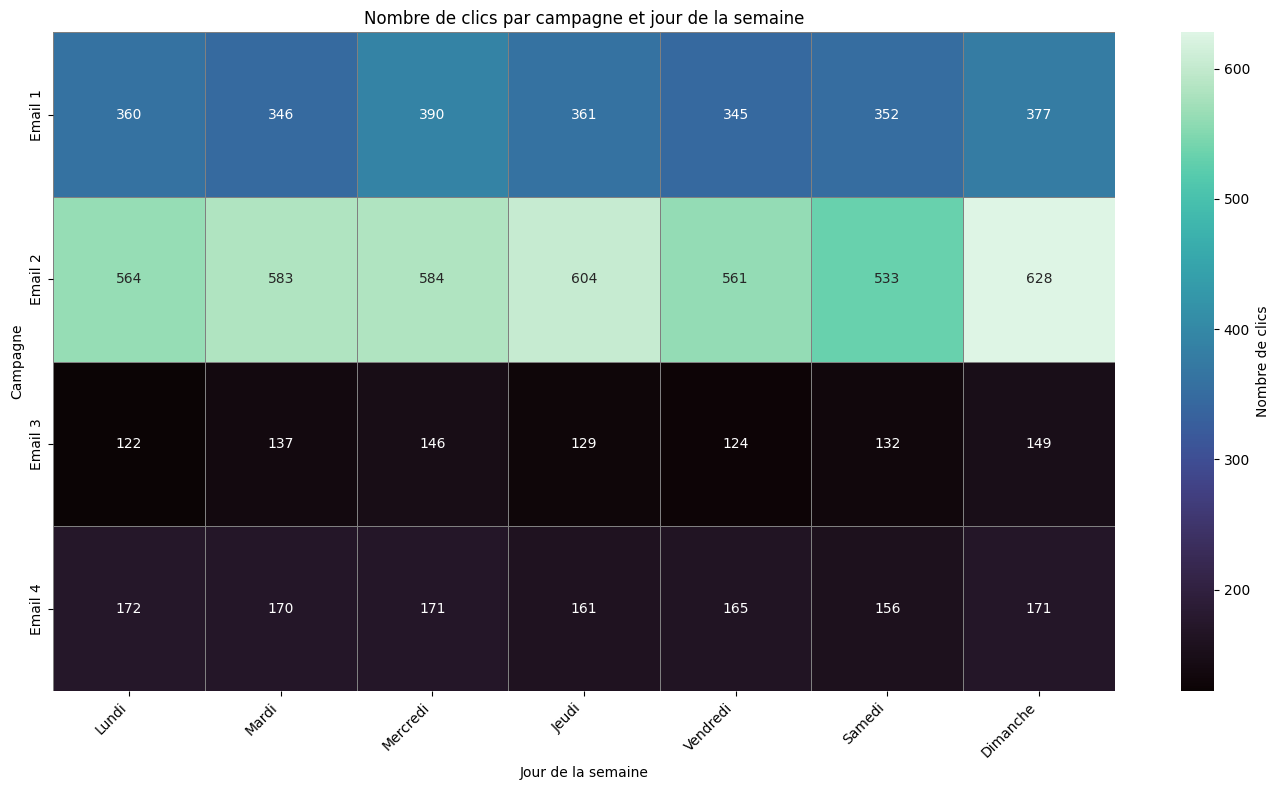

In [66]:
jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

# Préparation des données : valeurs uniquement, colonne 'Meilleure jours' exclue
data_heatmap = pivoted_click_d[jours_fr]

plt.figure(figsize=(14, 8))
sns.heatmap(
    data_heatmap,
    annot=True,
    fmt="d",
    cmap="mako",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Nombre de clics"},
)

plt.title("Nombre de clics par campagne et jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Campagne")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

#### Année-jours

In [67]:
# 1. Filtrer uniquement les emails ouverts
campagne_click_yd = (
    df_copy[df_copy["click_bool"] == 1]
    .groupby(["email_name", "year", "day_week", "periode_open"])
    .size()
    .reset_index(name="count")
)

# 2. Renommer les colonnes
campagne_click_yd = campagne_click_yd.rename(
    columns={"email_name": "Campagne", "day_week": "Jours", "year": "Année"}
)

# 3. Pivot
pivoted_click_yd = campagne_click_yd.pivot_table(
    index=["Campagne", "Année"],
    columns="Jours",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

# 4. Réordonner les périodes si nécessaire (optionnel)
jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_click_yd = pivoted_click_yd.reindex(columns=jours_fr, fill_value=0)
pivoted_click_yd = pivoted_click_yd.astype(int)

# 5. Ajouter la colonne "Meilleure période" (optionnel)
pivoted_click_yd["Meilleure jours"] = pivoted_click_yd.idxmax(axis=1)

# 6. Afficher le résultat
display(pivoted_click_yd)

Jours           Lundi  Mardi  Mercredi  Jeudi  Vendredi  Samedi  Dimanche  \
Campagne Année                                                              
Email 1  2019      84     80        81     85        69      82        70   
         2020      72     84        85     74        86      63        85   
         2021      70     64        80     64        81      82        82   
         2022      71     71        87     83        75      73        85   
         2023      63     47        57     55        34      52        55   
Email 2  2019     121    126       124    148       121     120       135   
         2020     124    125       117     96       131     135       126   
         2021     107    120       117    132       115      99       137   
         2022     125    125       138    121       121     123       128   
         2023      87     87        88    107        73      56       102   
Email 3  2019      30     25        31     38        24      32        23   
         2020      32     27        33     20        31      20        29   
         2021      17     35        29     28        27      30        37   
         2022      27     27        29     24        23      34        39   
         2023      16     23        24     19        19      16        21   
Email 4  2019      36     37        40     30        37      34        40   
         2020      38     30        43     33        42      28        48   
         2021      36     36        35     32        30      36        33   
         2022      31     37        22     43        40      30        26   
         2023      31     30        31     23        16      28        24   

Jours          Meilleure jours  
Campagne Année                  
Email 1  2019            Jeudi  
         2020         Vendredi  
         2021           Samedi  
         2022         Mercredi  
         2023            Lundi  
Email 2  2019            Jeudi  
         2020           Samedi  
         2021         Dimanche  
         2022         Mercredi  
         2023            Jeudi  
Email 3  2019            Jeudi  
         2020         Mercredi  
         2021         Dimanche  
         2022         Dimanche  
         2023         Mercredi  
Email 4  2019         Mercredi  
         2020         Dimanche  
         2021            Lundi  
         2022            Jeudi  
         2023            Lundi

#### Année-mois-jours

In [68]:
# 1. Filtrer uniquement les emails ouverts
campagne_click_ymd = (
    df_copy[df_copy["click_bool"] == 1]
    .groupby(["email_name", "year", "month", "day_week", "periode_open"])
    .size()
    .reset_index(name="count")
)

# 2. Renommer les colonnes
campagne_click_ymd = campagne_click_ymd.rename(
    columns={
        "email_name": "Campagne",
        "day_week": "Jours",
        "year": "Année",
        "month": "Mois",
    }
)

# 3. Pivot
pivoted_click_ymd = campagne_click_ymd.pivot_table(
    index=["Campagne", "Année", "Mois"],
    columns="Jours",
    values="count",
    aggfunc="sum",
    fill_value=0,
)

# 4. Réordonner les périodes si nécessaire (optionnel)
jours_fr = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
pivoted_click_ymd = pivoted_click_ymd.reindex(columns=jours_fr, fill_value=0)
pivoted_click_ymd = pivoted_click_ymd.astype(int)

# 5. Ajouter la colonne "Meilleure période" (optionnel)
pivoted_click_ymd["Meilleure jours"] = pivoted_click_ymd.idxmax(axis=1)

# 6. Afficher le résultat
display(pivoted_click_ymd)

Jours                Lundi  Mardi  Mercredi  Jeudi  Vendredi  Samedi  \
Campagne Année Mois                                                    
Email 1  2019  1         7      9         8      6         4       7   
               2         7      4         4      5         2       5   
               3        10      2         5      6         7       7   
               4         4      6         8      7         4       4   
               5         5      4         6      8         5       9   
...                    ...    ...       ...    ...       ...     ...   
Email 4  2023  4         4      2         3      3         1       6   
               5         5      5         2      3         3       2   
               6         3      3         5      3         3       4   
               7         5      5         3      1         3       5   
               8         6      4         4      5         1       5   

Jours                Dimanche Meilleure jours  
Campagne Année Mois                            
Email 1  2019  1            7           Mardi  
               2            4           Lundi  
               3            6           Lundi  
               4            5        Mercredi  
               5            3          Samedi  
...                       ...             ...  
Email 4  2023  4            1          Samedi  
               5            6        Dimanche  
               6            1        Mercredi  
               7            7        Dimanche  
               8            1           Lundi  

[224 rows x 8 columns]

#### Année-mois-jours-période

In [69]:
# 1. Filtrer uniquement les emails ouverts
campagne_click_ymd_p = (
    df_copy[df_copy["open_bool"] == 1]
    .groupby(["email_name", "year", "month", "day_week", "periode_open"])
    .size()
    .reset_index(name="count")
)

# 2. Renommer les colonnes
campagne_click_ymd_p = campagne_click_ymd_p.rename(
    columns={
        "email_name": "Campagne",
        "day_week": "Jours",
        "year": "Année",
        "month": "Mois",
        "periode_open": "Periode",
    }
)

# 3. Pivot pour avoir les périodes en colonnes et les jours en index
pivoted_ymd_p = campagne_click_ymd_p.pivot_table(
    index=["Campagne", "Année", "Mois", "Jours"],  # Jours dans l'index
    columns="Periode",  # Période en colonnes
    values="count",
    aggfunc="sum",
    fill_value=0,
)

# 4. Réordonner les périodes si nécessaire (optionnel)
periodes_order = [
    "Nuit",
    "Petit matin",
    "Matin",
    "Midi",
    "Après-midi",
    "Soir",
    "Fin de soirée",
]
pivoted_ymd_p = pivoted_ymd_p.reindex(columns=periodes_order, fill_value=0)
pivoted_ymd_p = pivoted_ymd_p.astype(int)

# 5. Ajouter la colonne "Meilleure période" (optionnel)
pivoted_ymd_p["Meilleure période"] = pivoted_ymd_p.idxmax(axis=1)

# 6. Afficher le résultat
display(pivoted_ymd_p)


Periode                       Nuit  Petit matin  Matin  Midi  Après-midi  \
Campagne Année Mois Jours                                                  
Email 1  2019  1    Dimanche     6            3      4     4           1   
                    Jeudi        3            1      6     4           5   
                    Lundi        6            1      0     0           5   
                    Mardi        8            2      4     4           5   
                    Mercredi     3            1      3     2           5   
...                            ...          ...    ...   ...         ...   
Email 4  2023  8    Lundi        3            1      3     1           5   
                    Mardi        6            1      2     2           2   
                    Mercredi     2            1      0     2           4   
                    Samedi       4            2      0     1           3   
                    Vendredi     3            0      0     1           1   

Periode                       Soir  Fin de soirée Meilleure période  
Campagne Année Mois Jours                                            
Email 1  2019  1    Dimanche     4              3              Nuit  
                    Jeudi        6              1             Matin  
                    Lundi        4              3              Nuit  
                    Mardi        1              5              Nuit  
                    Mercredi     5              3        Après-midi  
...                            ...            ...               ...  
Email 4  2023  8    Lundi        1              0        Après-midi  
                    Mardi        3              3              Nuit  
                    Mercredi     1              1        Après-midi  
                    Samedi       0              1              Nuit  
                    Vendredi     2              3              Nuit  

[1568 rows x 8 columns]